<a href="https://colab.research.google.com/github/BlancoAnna/DL--2025/blob/main/Problems%2011%20-%20Metric%20Learning/P11_Metric_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open In SageMaker Studio Lab](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github/dkaratzas/DL2022-23/blob/main/Problems%2010%20-%20Metric%20Learning/P10_Metric_Learning.ipynb)

# Metric Learning

In this practical, we will calculate 2-dimensional embeddings (so that we can easily visualise them) using different approaches: a classification network, a siamese network, and a triplet network. We will use FashionMNIST.

First some preliminary stuff. Apart from typical imports, we define also two functions that will help us later on to generate embeddings for all our data and to plot them in a 2D scatter plot.

In [1]:
import os
import random

import torch
from torch.optim import lr_scheduler
import torch.optim as optim

import numpy as np

import matplotlib.pyplot as plt

from torchvision.datasets import FashionMNIST
from torchvision import transforms
from torchvision.utils import make_grid
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from PIL import Image

In [2]:
fashion_mnist_classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

def plot_embeddings(embeddings, targets, xlim=None, ylim=None):
    plt.figure(figsize=(10,10))
    for i in range(10):
        inds = np.where(targets==i)[0]
        plt.scatter(embeddings[inds,0], embeddings[inds,1], alpha=0.5, color=colors[i])
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    plt.legend(fashion_mnist_classes)


def extract_embeddings(dataloader, model):
    with torch.no_grad():
        model.eval()
        embeddings = np.zeros((len(dataloader.dataset), 2))
        labels = np.zeros(len(dataloader.dataset))
        k = 0
        for images, target in dataloader:
            images = images.cuda()
            embeddings[k:k+len(images)] = model.get_embedding(images).data.cpu().numpy()
            labels[k:k+len(images)] = target.numpy()
            k += len(images)
    return embeddings, labels

## Import data

Import the FashionMNIST data and define datasets and data loaders.

In [3]:
mean, std = 0.28604059698879553, 0.35302424451492237

train_dataset = FashionMNIST('data', train=True, download=True,
                             transform=transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Normalize((mean,), (std,))
                             ]))
test_dataset = FashionMNIST('data', train=False, download=True,
                            transform=transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((mean,), (std,))
                            ]))

100%|██████████| 26.4M/26.4M [00:02<00:00, 11.9MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 201kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.68MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 12.2MB/s]


In [4]:
#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#If this cell fails you need to change the runtime of your colab notebook to GPU
# Go to Runtime -> Change Runtime Type and select GPU
assert torch.cuda.is_available(), "GPU is not enabled"

In [5]:
# Set up data loaders
batch_size = 256
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## The Embedding Network

To do the embedding always in the same manner, we will define the embedding part once, and then reuse it with different networks. The embedding we will use is a small CNN architecture, followed by a couple of FC layers that bring down the output to 2 dimensions (so that we can plot the results later).

In [6]:
class EmbeddingNet(nn.Module):
    def __init__(self):
        super(EmbeddingNet, self).__init__()
        self.convnet = nn.Sequential(nn.Conv2d(1, 32, 5), nn.PReLU(),
                                     nn.MaxPool2d(2, stride=2),
                                     nn.Conv2d(32, 64, 5), nn.PReLU(),
                                     nn.MaxPool2d(2, stride=2))

        self.fc = nn.Sequential(nn.Linear(64 * 4 * 4, 256),
                                nn.PReLU(),
                                nn.Linear(256, 256),
                                nn.PReLU(),
                                nn.Linear(256, 2)
                                )

    def forward(self, x):
        output = self.convnet(x)
        output = output.view(output.size()[0], -1)
        output = self.fc(output)
        return output

    def get_embedding(self, x):
        return self.forward(x)

## Classification Head

The first embedding we will learn is by using a classification head. We define our classification model to use our standard embedding to 2 dimensions, then bring it up to the number of classes (10 in the case if FashionMNIST) and return the logits. We then train it using `torch.nn.CrossEntropyLoss()`.

In [7]:
class ClassificationNet(nn.Module):
    def __init__(self, embedding_net, n_classes):
        super(ClassificationNet, self).__init__()
        self.embedding_net = embedding_net
        self.n_classes = n_classes
        self.nonlinear = nn.PReLU()
        self.fc1 = nn.Linear(2, n_classes) #From 2 to 10

    def forward(self, x):
        output = self.embedding_net(x)
        output = self.nonlinear(output)
        return self.fc1(output)

    def get_embedding(self, x):
        return self.nonlinear(self.embedding_net(x))

In [8]:
def train_epoch(train_loader, model, criterion, optimizer):

    model.train()
    losses = []
    total_loss = 0
    correct = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        target = target.to(device)
        data = data.to(device)

        optimizer.zero_grad()

        outputs = model(data)

        loss = criterion(outputs, target)
        losses.append(loss.item())
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

        # Evaluate on training set
        pred = outputs.max(1)[1] # Bc the max gives you a tuple woth the maximum value and its label
        correct += pred.eq(target.view_as(pred)).sum().item()

        if batch_idx % 20 == 0:
            print("Iteration {}: Loss = {}".format(batch_idx, loss.item()))

    total_loss /= (batch_idx + 1)
    accuracy = 100. * correct / len(train_loader.dataset)
    return total_loss, accuracy

@torch.no_grad()
def test_epoch(val_loader, model, criterion):

    model.eval()
    val_loss = 0
    correct = 0

    for batch_idx, (data, target) in enumerate(val_loader):
        target = target.to(device)
        data = data.to(device)

        outputs = model(data)

        loss = criterion(outputs, target)
        val_loss += loss.item()

        pred = outputs.max(1)[1]
        correct += pred.eq(target.view_as(pred)).sum().item()

    accuracy = 100. * correct / len(val_loader.dataset)
    return val_loss, accuracy

In [9]:
embedding_net = EmbeddingNet().to(device)

n_classes = 10
model = ClassificationNet(embedding_net, n_classes=n_classes)
model.to(device)

criterion = torch.nn.CrossEntropyLoss()

lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)

scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)

In [10]:
n_epochs = 10 # Do 10 epochs
for epoch in range(n_epochs):

    # Train stage
    train_loss, acc = train_epoch(train_loader, model, criterion, optimizer)

    scheduler.step()
    message = 'Epoch: {}/{}. Train set: Average loss: {:.4f} Accuracy: {:.2f}'.format(epoch + 1, n_epochs, train_loss, acc)

    # Validation stage
    val_loss, acc = test_epoch(test_loader, model, criterion)
    val_loss /= len(test_loader)

    message += '\nEpoch: {}/{}. Validation set: Average loss: {:.4f} Accuracy: {:.2f}'.format(epoch + 1, n_epochs, val_loss, acc)

    print(message)

Iteration 0: Loss = 2.354006767272949
Iteration 20: Loss = 1.7989648580551147
Iteration 40: Loss = 1.5126993656158447
Iteration 60: Loss = 1.4268627166748047
Iteration 80: Loss = 1.385191559791565
Iteration 100: Loss = 1.2504713535308838
Iteration 120: Loss = 1.2071336507797241
Iteration 140: Loss = 1.1058999300003052
Iteration 160: Loss = 0.975037157535553
Iteration 180: Loss = 1.0193732976913452
Iteration 200: Loss = 0.9891228079795837
Iteration 220: Loss = 0.917424201965332
Epoch: 1/10. Train set: Average loss: 1.2416 Accuracy: 50.96
Epoch: 1/10. Validation set: Average loss: 0.9078 Accuracy: 65.81
Iteration 0: Loss = 0.9878587126731873
Iteration 20: Loss = 0.8566840887069702
Iteration 40: Loss = 0.7676371335983276
Iteration 60: Loss = 0.7692062854766846
Iteration 80: Loss = 0.7731918692588806
Iteration 100: Loss = 0.8851150274276733
Iteration 120: Loss = 0.6089362502098083
Iteration 140: Loss = 0.6423556208610535
Iteration 160: Loss = 0.5842037200927734
Iteration 180: Loss = 0.6490

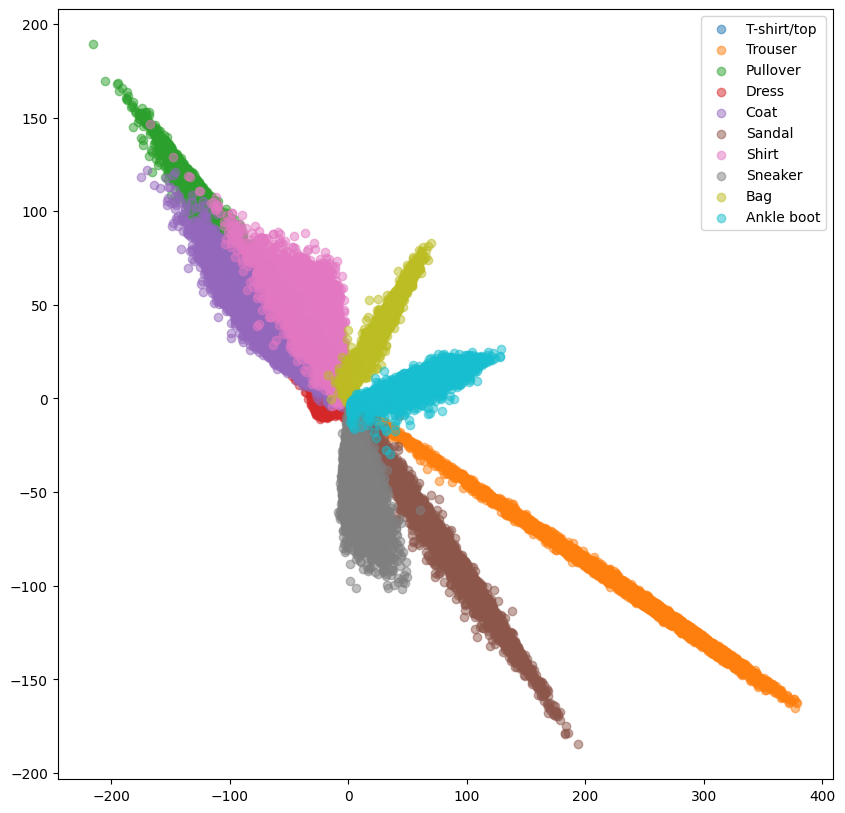

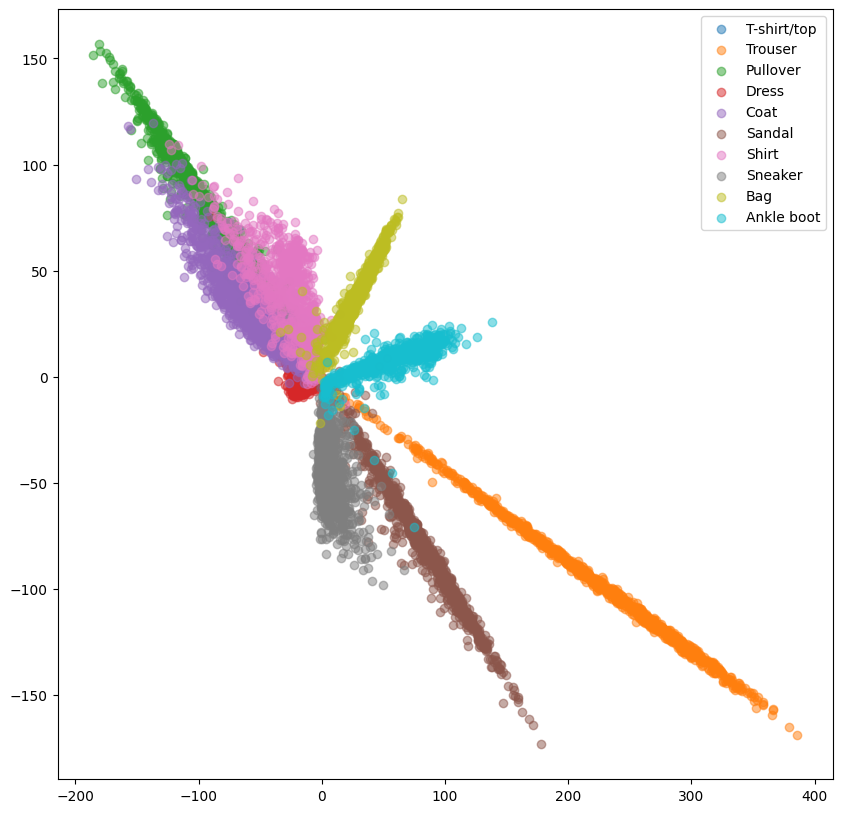

In [11]:
train_embeddings_baseline, train_labels_baseline = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_baseline, train_labels_baseline)
val_embeddings_baseline, val_labels_baseline = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_baseline, val_labels_baseline)

## Siamese Head

We will repeat the process with a siamese network, but in order to do that we need first to create a different dataset, that creates positive and negative pairs from the original dataset. The pairs will be generated on the fly, randomly, while training. While testing, we will maintain the same pairs always so that comparisons would make sense.

Note that here we just aim to create valid pairs, we do not do any mining (we do not care if they are easy, semi-hard or hard).

In [12]:
class SiameseDataset(Dataset):
    """
    Train: For each sample creates randomly a positive or a negative pair
    Test: Creates fixed pairs for testing
    """

    def __init__(self, mnist_dataset):
        self.mnist_dataset = mnist_dataset

        self.train = self.mnist_dataset.train
        self.transform = self.mnist_dataset.transform

        self.labels = self.mnist_dataset.targets
        self.data = self.mnist_dataset.data
        self.labels_set = set(self.labels.numpy())
        self.label_to_indices = {label: np.where(self.labels.numpy() == label)[0]
                                 for label in self.labels_set}

        if not self.train:
            # generate fixed pairs for testing once at initialisation
            random_state = np.random.RandomState(29) # Fix random seed for testing

            positive_pairs = [[i,
                               random_state.choice(self.label_to_indices[self.labels[i].item()]),
                               1]
                              for i in range(0, len(self.data), 2)]

            negative_pairs = [[i,
                               random_state.choice(self.label_to_indices[
                                                       np.random.choice(
                                                           list(self.labels_set - set([self.labels[i].item()]))
                                                       )
                                                   ]),
                               0]
                              for i in range(1, len(self.data), 2)]
            self.test_pairs = positive_pairs + negative_pairs

    def __getitem__(self, index):
        if self.train:
            # Generate a positive or negative pair on the fly
            target = np.random.randint(0, 2) # randomly select positive or negative
            img1, label1 = self.data[index], self.labels[index].item()
            if target == 1: # Generate a POSITIVE pair
                siamese_index = index
                while siamese_index == index: # Make sure we do not use ourself as the positive pair
                    siamese_index = np.random.choice(self.label_to_indices[label1])
            else: # Generate a NEGATIVE pair
                siamese_label = np.random.choice(list(self.labels_set - set([label1])))
                siamese_index = np.random.choice(self.label_to_indices[siamese_label])
            img2 = self.data[siamese_index]
        else:
            # Just retrieve the pair from the saved test pairs we generated at init
            img1 = self.data[self.test_pairs[index][0]]
            img2 = self.data[self.test_pairs[index][1]]
            target = self.test_pairs[index][2]

        # Get a PIL image to pass through transform
        img1 = Image.fromarray(img1.numpy(), mode='L')
        img2 = Image.fromarray(img2.numpy(), mode='L')
        if self.transform is not None:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
        return img1, img2, target


    def __len__(self):
        return len(self.mnist_dataset)

Now we are ready to define our siamese net which just takes in one training sample (which now comprises a pair of images) and embeds them using our embedding function. It returns the two embeddings.

In [13]:
class SiameseNet(nn.Module):
    def __init__(self, embedding_net):
        super(SiameseNet, self).__init__()
        self.embedding_net = embedding_net

    def forward(self, x1, x2):
        output1 = self.embedding_net(x1)
        output2 = self.embedding_net(x2)
        return output1, output2

    def get_embedding(self, x):
        return self.embedding_net(x)

The next thing to do is to define our loss function for the case of the siamese. In this case, we need a function that takes as input TWO vectors and one target that indicates if they are supposed to be a positive pair, or a negative pair, and implements the function:

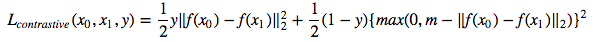

In [14]:
class ContrastiveLoss(nn.Module):
    """
    Max-Margin Contrastive loss
    Takes embeddings of two samples and a target label == 1 if samples are from the same class and label == 0 otherwise
    """

    def __init__(self, margin):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
        self.eps = 1e-9

    def forward(self, output1, output2, target, size_average=True):
        distances = (output2 - output1).pow(2).sum(1)  # squared distances
        # losses = 0.5 * (target.float() * distances + (1 - target).float() * max(0, self.margin - (distances + self.eps).sqrt()).pow(2)) equivalent to
        losses = 0.5 * (target.float() * distances + (1 - target).float() * F.relu(self.margin - (distances + self.eps).sqrt()).pow(2))
        return losses.mean() if size_average else losses.sum()

We will also redefine the training and validation loops, as now the data loader gives us 2 samples and the loss function expects 2 samples.

In [15]:
def train_epoch_siamese(train_loader, model, criterion, optimizer):

    model.train()
    losses = []
    total_loss = 0
    correct = 0

    for batch_idx, (data1, data2, target) in enumerate(train_loader):
        target = target.to(device)
        data1 = data1.to(device)
        data2 = data2.to(device)

        optimizer.zero_grad()

        output1, output2 = model(data1, data2)

        # The loss is the only thing we can report here
        loss = criterion(output1, output2, target)
        losses.append(loss.item())
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

        if batch_idx % 20 == 0:
            print("Iteration {}: Loss = {}".format(batch_idx, loss.item()))

    total_loss /= (batch_idx + 1)
    return total_loss

@torch.no_grad()
def test_epoch_siamese(val_loader, model, criterion):

    model.eval()
    val_loss = 0
    correct = 0

    for batch_idx, (data1, data2, target) in enumerate(val_loader):
        target = target.to(device)
        data1 = data1.to(device)
        data2 = data2.to(device)

        output1, output2 = model(data1, data2)

        loss = criterion(output1, output2, target)
        val_loss += loss.item()

    return val_loss

In [16]:
siamese_train_dataset = SiameseDataset(train_dataset) # Returns pairs of images and target same/different
siamese_test_dataset = SiameseDataset(test_dataset)   # Note that the train datasets has self.train == True, and the test has self.train == False

batch_size = 256
siamese_train_loader = DataLoader(siamese_train_dataset, batch_size=batch_size, shuffle=True)
siamese_test_loader = DataLoader(siamese_test_dataset, batch_size=batch_size, shuffle=False)

margin = 1.

embedding_net = EmbeddingNet()
model = SiameseNet(embedding_net)
model.to(device)

criterion = ContrastiveLoss(margin)

lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)

In [17]:
n_epochs = 10 # Do 10 epochs
for epoch in range(n_epochs):

        # Train stage
        train_loss = train_epoch_siamese(siamese_train_loader, model, criterion, optimizer)
        scheduler.step()

        message = 'Epoch: {}/{}. Train set: Average loss: {:.4f}'.format(epoch + 1, n_epochs, train_loss)

        # Validation stage
        val_loss = test_epoch_siamese(siamese_test_loader, model, criterion)
        val_loss /= len(siamese_test_loader)

        message += '\nEpoch: {}/{}. Validation set: Average loss: {:.4f}'.format(epoch + 1, n_epochs, val_loss)

        print(message)

Iteration 0: Loss = 0.2389904260635376
Iteration 20: Loss = 0.06820185482501984
Iteration 40: Loss = 0.05751080811023712
Iteration 60: Loss = 0.05574400722980499
Iteration 80: Loss = 0.0578787587583065
Iteration 100: Loss = 0.0479353666305542
Iteration 120: Loss = 0.05245744436979294
Iteration 140: Loss = 0.043144289404153824
Iteration 160: Loss = 0.048170506954193115
Iteration 180: Loss = 0.03647483140230179
Iteration 200: Loss = 0.0443272702395916
Iteration 220: Loss = 0.04348066449165344
Epoch: 1/10. Train set: Average loss: 0.0502
Epoch: 1/10. Validation set: Average loss: 0.0424
Iteration 0: Loss = 0.044896870851516724
Iteration 20: Loss = 0.04561169445514679
Iteration 40: Loss = 0.028491899371147156
Iteration 60: Loss = 0.034766968339681625
Iteration 80: Loss = 0.04260934516787529
Iteration 100: Loss = 0.03816618025302887
Iteration 120: Loss = 0.038930051028728485
Iteration 140: Loss = 0.03638138249516487
Iteration 160: Loss = 0.03199254721403122
Iteration 180: Loss = 0.030864229

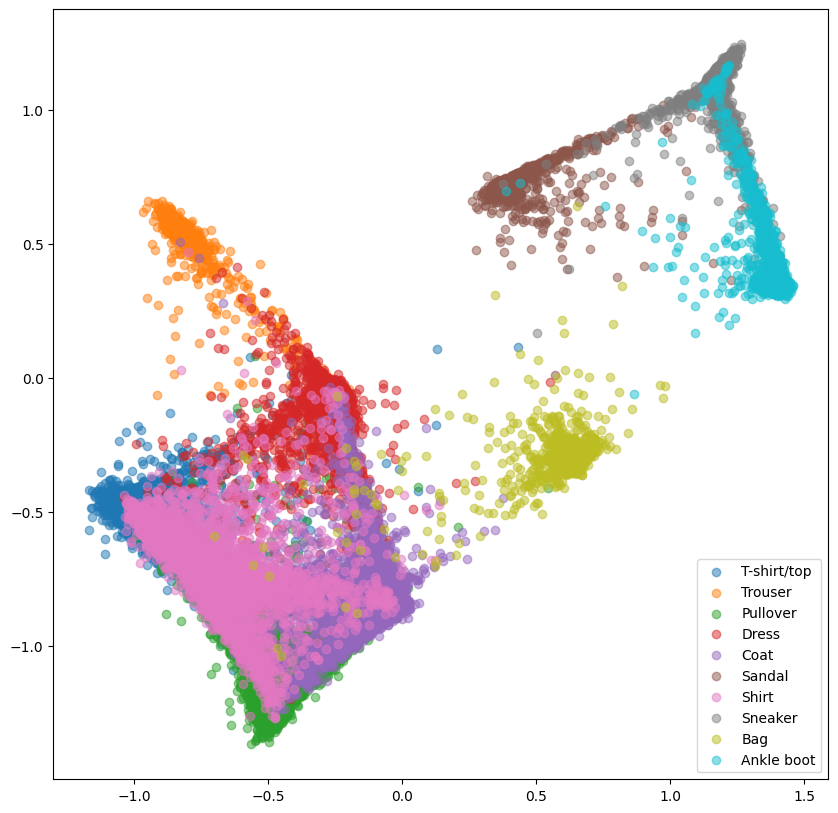

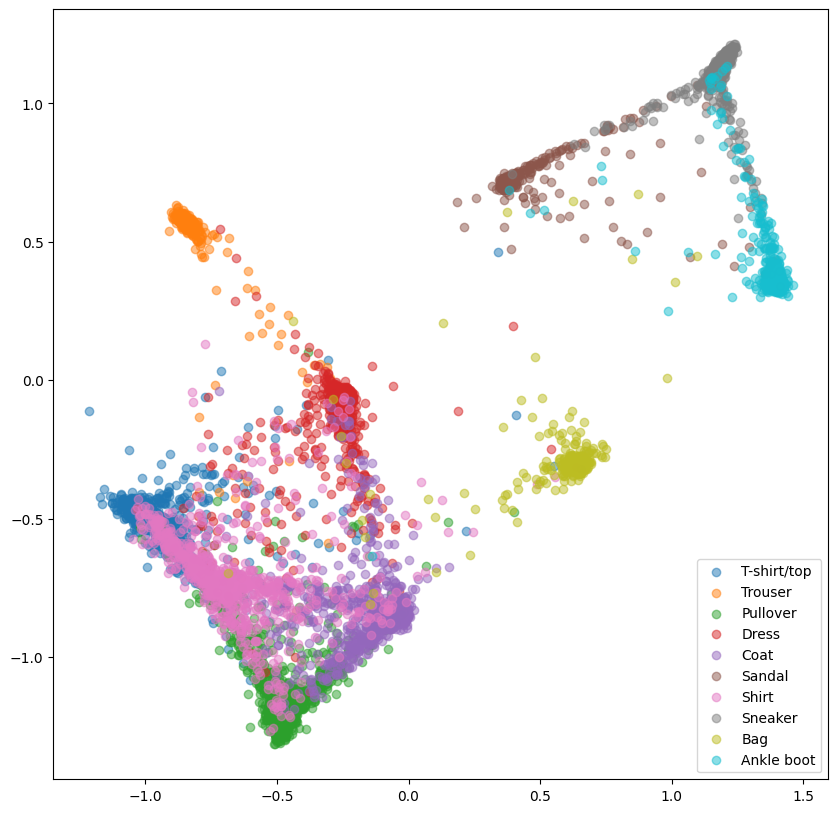

In [18]:
train_embeddings_baseline, train_labels_baseline = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_baseline, train_labels_baseline)
val_embeddings_baseline, val_labels_baseline = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_baseline, val_labels_baseline)

There are couple of problems with siamese and (triplet) networks the way we have implemented them up to this point.

- The number of possible pairs/triplets grows quadratically/cubically with the number of examples. It's infeasible to process them all
- We generate pairs/triplets randomly. As the training continues, more and more pairs/triplets are easy to deal with (their loss value is very small or even 0), preventing the network from training. We need to provide the network with hard examples.
- Each image that is fed to the network is used only for computation of contrastive/triplet loss for only one pair/triplet. The computation is somewhat wasted; once the embedding is computed, it could be reused for many pairs/triplets.

To deal with that efficiently, we'll feed a network with standard mini-batches as we did for classification. The loss function will be responsible for selection of hard pairs and triplets within mini-batch. In this case, if we feed the network with 16 images per 10 classes, we can process up to $159*160/2 = 12720$ pairs and $10*16*15/2*(9*16) = 172800$ triplets, compared to 80 pairs and 53 triplets in previous implementation.

## Triplet Loss

We will now train FashionMNIST using a semi-hard Triplet Mining strategy, and visualize the embeddings.

We will not implement any miner, loss or distance function by hand. Instead we will use [The Pytorch Metric Learning Library](https://github.com/KevinMusgrave/pytorch-metric-learning) (installed in the cell below) which implements everything we need.

Check its [docs](https://kevinmusgrave.github.io/pytorch-metric-learning/) so that you get an idea of how to use it.

Install the required packages below. Uncomment the corresponding cell to use the package manager that suits your installation (for Google Colab, that would be pip).

In [19]:
#%conda install -y -c metric-learning pytorch-metric-learning=2.1.1
#%conda install -y -c conda-forge faiss-gpu=1.6.5

In [20]:
!pip install pytorch-metric-learning==2.1.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 93.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 63.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 65.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 41.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

In [21]:
!pip install faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 68.6 MB/s eta 0:00:00


In [22]:
from pytorch_metric_learning import losses, miners, distances, testers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator

We will redefine our training and test loops to use this library. The idea is that first we embedd all the data inside our batch. Then we will ask a *Miner* to find good triplets. The list of triplets (a list of tuples with indices) will be passed on to the loss function, that will calculate the loss based on them.

In [23]:
def train(model, loss_func, mining_func, train_loader, optimizer, epoch):
    model.train()
    total_loss = 0

    for batch_idx, (data, labels) in enumerate(train_loader):
        data = data.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        embeddings = model(data)

        indices_tuple = mining_func(embeddings, labels)
        loss = loss_func(embeddings, labels, indices_tuple)

        total_loss += loss.item()
        loss.backward()

        optimizer.step()
        if batch_idx % 20 == 0:
            print("Epoch {} Iteration {}: Loss = {}, Number of mined triplets = {}".format(epoch, batch_idx, loss, mining_func.num_triplets))

    return total_loss / (batch_idx + 1)

def get_all_embeddings(dataset, model):
    tester = testers.BaseTester(dataloader_num_workers=2)
    return tester.get_all_embeddings(dataset, model)

def test(train_set, test_set, model, accuracy_calculator):
    model.eval()
    train_embeddings, train_labels = get_all_embeddings(train_set, model)
    test_embeddings, test_labels = get_all_embeddings(test_set, model)

    print("Computing accuracy")
    accuracies = accuracy_calculator.get_accuracy(query = train_embeddings, reference = test_embeddings, query_labels = train_labels, reference_labels = test_labels)

    print("Test set accuracy (Precision@1) = {}".format(accuracies["precision_at_1"]))


We now need to define our miner. Here we will use a `TripletMarginMiner` and cosine similarity to measure the distance between embeddings. We will also use an "accuracy" calculator. The actual metric we will be using is a *precision at 1*, which is just a fancy way to ask whether the 1st nearest neighbour of each sample is of the same class.

https://kevinmusgrave.github.io/pytorch-metric-learning/accuracy_calculation/

In [24]:
distance = distances.CosineSimilarity()
mining_func = miners.TripletMarginMiner(margin = 0.2, distance=distance, type_of_triplets="all") #All useful ones
accuracy_calculator = AccuracyCalculator(include=("precision_at_1",), k = 1)

Define the datasets, dataloaders, and the model to use. The model we will use here is just the embedding net on its own.

In [25]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

model = EmbeddingNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_func = losses.TripletMarginLoss(margin=1., distance = distance)

Epoch 1 Iteration 0: Loss = 0.9978311061859131, Number of mined triplets = 1434489
Epoch 1 Iteration 20: Loss = 0.9764627814292908, Number of mined triplets = 1296117
Epoch 1 Iteration 40: Loss = 0.9867464900016785, Number of mined triplets = 826025
Epoch 1 Iteration 60: Loss = 0.9951805472373962, Number of mined triplets = 608789
Epoch 1 Iteration 80: Loss = 0.9774190187454224, Number of mined triplets = 573213
Epoch 1 Iteration 100: Loss = 1.0009320974349976, Number of mined triplets = 441071
Epoch 1 Iteration 120: Loss = 0.990047812461853, Number of mined triplets = 438015
Epoch 1 Iteration 140: Loss = 0.9947689771652222, Number of mined triplets = 464778
Epoch 1 Iteration 160: Loss = 1.0157639980316162, Number of mined triplets = 384340
Epoch 1 Iteration 180: Loss = 0.9643893241882324, Number of mined triplets = 323385
Epoch 1 Iteration 200: Loss = 1.0417958498001099, Number of mined triplets = 414711
Epoch 1 Iteration 220: Loss = 0.9847819805145264, Number of mined triplets = 4749

100%|██████████| 313/313 [00:02<00:00, 136.05it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.5174500000000001
Epoch 2 Iteration 0: Loss = 0.9895181655883789, Number of mined triplets = 386741
Epoch 2 Iteration 20: Loss = 1.022438406944275, Number of mined triplets = 399605
Epoch 2 Iteration 40: Loss = 0.9523282051086426, Number of mined triplets = 393417
Epoch 2 Iteration 60: Loss = 0.9788365364074707, Number of mined triplets = 388636
Epoch 2 Iteration 80: Loss = 0.9788651466369629, Number of mined triplets = 417303
Epoch 2 Iteration 100: Loss = 0.971073567867279, Number of mined triplets = 299465
Epoch 2 Iteration 120: Loss = 1.0015980005264282, Number of mined triplets = 223411
Epoch 2 Iteration 140: Loss = 1.001712441444397, Number of mined triplets = 288406
Epoch 2 Iteration 160: Loss = 1.0186870098114014, Number of mined triplets = 353144
Epoch 2 Iteration 180: Loss = 0.9909220337867737, Number of mined triplets = 282972
Epoch 2 Iteration 200: Loss = 0.9963241815567017, Number of mined triplets = 293489
Epoch 2 Itera

100%|██████████| 313/313 [00:02<00:00, 128.71it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.6705166666666666
Epoch 3 Iteration 0: Loss = 0.9764959216117859, Number of mined triplets = 234040
Epoch 3 Iteration 20: Loss = 1.0044411420822144, Number of mined triplets = 220247
Epoch 3 Iteration 40: Loss = 1.022869348526001, Number of mined triplets = 319522
Epoch 3 Iteration 60: Loss = 0.9919046759605408, Number of mined triplets = 244874
Epoch 3 Iteration 80: Loss = 1.0013340711593628, Number of mined triplets = 318467
Epoch 3 Iteration 100: Loss = 0.9932183027267456, Number of mined triplets = 266314
Epoch 3 Iteration 120: Loss = 0.9812314510345459, Number of mined triplets = 280691
Epoch 3 Iteration 140: Loss = 0.999706506729126, Number of mined triplets = 275667
Epoch 3 Iteration 160: Loss = 1.0060917139053345, Number of mined triplets = 245046
Epoch 3 Iteration 180: Loss = 0.9845929145812988, Number of mined triplets = 230397
Epoch 3 Iteration 200: Loss = 0.9652976393699646, Number of mined triplets = 272377
Epoch 3 Iter

100%|██████████| 313/313 [00:02<00:00, 133.45it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.7102333333333334
Epoch 4 Iteration 0: Loss = 1.004911184310913, Number of mined triplets = 223624
Epoch 4 Iteration 20: Loss = 0.9682753682136536, Number of mined triplets = 245605
Epoch 4 Iteration 40: Loss = 0.9921327233314514, Number of mined triplets = 230020
Epoch 4 Iteration 60: Loss = 1.0006848573684692, Number of mined triplets = 202540
Epoch 4 Iteration 80: Loss = 1.0147027969360352, Number of mined triplets = 269325
Epoch 4 Iteration 100: Loss = 0.989809513092041, Number of mined triplets = 287338
Epoch 4 Iteration 120: Loss = 0.9714982509613037, Number of mined triplets = 281768
Epoch 4 Iteration 140: Loss = 1.018540382385254, Number of mined triplets = 250623
Epoch 4 Iteration 160: Loss = 0.9745619297027588, Number of mined triplets = 172772
Epoch 4 Iteration 180: Loss = 1.0350886583328247, Number of mined triplets = 229507
Epoch 4 Iteration 200: Loss = 0.9922810792922974, Number of mined triplets = 212976
Epoch 4 Itera

100%|██████████| 313/313 [00:03<00:00, 98.30it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.7480333333333333
Epoch 5 Iteration 0: Loss = 1.0142438411712646, Number of mined triplets = 297465
Epoch 5 Iteration 20: Loss = 0.9927676320075989, Number of mined triplets = 172447
Epoch 5 Iteration 40: Loss = 1.0273339748382568, Number of mined triplets = 180713
Epoch 5 Iteration 60: Loss = 1.0603547096252441, Number of mined triplets = 335277
Epoch 5 Iteration 80: Loss = 0.9992140531539917, Number of mined triplets = 307507
Epoch 5 Iteration 100: Loss = 0.9832240343093872, Number of mined triplets = 214670
Epoch 5 Iteration 120: Loss = 0.9730186462402344, Number of mined triplets = 212705
Epoch 5 Iteration 140: Loss = 0.9965867400169373, Number of mined triplets = 260504
Epoch 5 Iteration 160: Loss = 0.9862024784088135, Number of mined triplets = 194250
Epoch 5 Iteration 180: Loss = 0.9857946634292603, Number of mined triplets = 291350
Epoch 5 Iteration 200: Loss = 0.9753124713897705, Number of mined triplets = 194536
Epoch 5 It

100%|██████████| 313/313 [00:02<00:00, 138.63it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.7551833333333333
Epoch 6 Iteration 0: Loss = 0.9890968203544617, Number of mined triplets = 217266
Epoch 6 Iteration 20: Loss = 0.9699349999427795, Number of mined triplets = 216314
Epoch 6 Iteration 40: Loss = 0.9886842966079712, Number of mined triplets = 211191
Epoch 6 Iteration 60: Loss = 1.0228098630905151, Number of mined triplets = 252302
Epoch 6 Iteration 80: Loss = 0.9829936027526855, Number of mined triplets = 209877
Epoch 6 Iteration 100: Loss = 0.9735475182533264, Number of mined triplets = 160548
Epoch 6 Iteration 120: Loss = 0.9611285924911499, Number of mined triplets = 269884
Epoch 6 Iteration 140: Loss = 0.9806622266769409, Number of mined triplets = 169691
Epoch 6 Iteration 160: Loss = 0.9954469203948975, Number of mined triplets = 214683
Epoch 6 Iteration 180: Loss = 0.9919975399971008, Number of mined triplets = 227706
Epoch 6 Iteration 200: Loss = 1.037489652633667, Number of mined triplets = 380611
Epoch 6 Ite

100%|██████████| 313/313 [00:03<00:00, 91.79it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.7481333333333333
Epoch 7 Iteration 0: Loss = 0.9523898959159851, Number of mined triplets = 267898
Epoch 7 Iteration 20: Loss = 0.9656647443771362, Number of mined triplets = 199743
Epoch 7 Iteration 40: Loss = 0.964133083820343, Number of mined triplets = 214487
Epoch 7 Iteration 60: Loss = 0.9868885278701782, Number of mined triplets = 269813
Epoch 7 Iteration 80: Loss = 0.9754543900489807, Number of mined triplets = 198014
Epoch 7 Iteration 100: Loss = 0.9857813715934753, Number of mined triplets = 223896
Epoch 7 Iteration 120: Loss = 0.9493545293807983, Number of mined triplets = 205090
Epoch 7 Iteration 140: Loss = 0.9776849746704102, Number of mined triplets = 186133
Epoch 7 Iteration 160: Loss = 0.9662914872169495, Number of mined triplets = 153674
Epoch 7 Iteration 180: Loss = 0.9863705039024353, Number of mined triplets = 202049
Epoch 7 Iteration 200: Loss = 0.9955940246582031, Number of mined triplets = 171500
Epoch 7 Ite

100%|██████████| 313/313 [00:02<00:00, 138.19it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.7763666666666666
Epoch 8 Iteration 0: Loss = 0.9786326289176941, Number of mined triplets = 178401
Epoch 8 Iteration 20: Loss = 0.9639143347740173, Number of mined triplets = 228221
Epoch 8 Iteration 40: Loss = 0.9891350865364075, Number of mined triplets = 163347
Epoch 8 Iteration 60: Loss = 0.9808140397071838, Number of mined triplets = 243841
Epoch 8 Iteration 80: Loss = 0.9557660222053528, Number of mined triplets = 191881
Epoch 8 Iteration 100: Loss = 0.9521923065185547, Number of mined triplets = 177709
Epoch 8 Iteration 120: Loss = 0.9458277225494385, Number of mined triplets = 196697
Epoch 8 Iteration 140: Loss = 0.9473092555999756, Number of mined triplets = 253385
Epoch 8 Iteration 160: Loss = 0.991960346698761, Number of mined triplets = 236941
Epoch 8 Iteration 180: Loss = 1.0096403360366821, Number of mined triplets = 160995
Epoch 8 Iteration 200: Loss = 1.0044655799865723, Number of mined triplets = 204074
Epoch 8 Ite

100%|██████████| 313/313 [00:02<00:00, 119.07it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.7891
Epoch 9 Iteration 0: Loss = 0.9674911499023438, Number of mined triplets = 178805
Epoch 9 Iteration 20: Loss = 0.9528095722198486, Number of mined triplets = 163588
Epoch 9 Iteration 40: Loss = 0.9941377639770508, Number of mined triplets = 198763
Epoch 9 Iteration 60: Loss = 0.9726582169532776, Number of mined triplets = 214928
Epoch 9 Iteration 80: Loss = 1.0040271282196045, Number of mined triplets = 190835
Epoch 9 Iteration 100: Loss = 0.9703038930892944, Number of mined triplets = 232123
Epoch 9 Iteration 120: Loss = 0.9772125482559204, Number of mined triplets = 194574
Epoch 9 Iteration 140: Loss = 0.9605830907821655, Number of mined triplets = 128234
Epoch 9 Iteration 160: Loss = 1.0055432319641113, Number of mined triplets = 182733
Epoch 9 Iteration 180: Loss = 0.9752522706985474, Number of mined triplets = 171077
Epoch 9 Iteration 200: Loss = 1.0543614625930786, Number of mined triplets = 238527
Epoch 9 Iteration 220:

100%|██████████| 313/313 [00:02<00:00, 138.24it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.7984
Epoch 10 Iteration 0: Loss = 0.9938824772834778, Number of mined triplets = 200376
Epoch 10 Iteration 20: Loss = 0.9641097784042358, Number of mined triplets = 151945
Epoch 10 Iteration 40: Loss = 0.96580970287323, Number of mined triplets = 166998
Epoch 10 Iteration 60: Loss = 0.962407648563385, Number of mined triplets = 199807
Epoch 10 Iteration 80: Loss = 0.9747297167778015, Number of mined triplets = 184018
Epoch 10 Iteration 100: Loss = 0.9726758599281311, Number of mined triplets = 165394
Epoch 10 Iteration 120: Loss = 0.9560419321060181, Number of mined triplets = 131639
Epoch 10 Iteration 140: Loss = 1.0034009218215942, Number of mined triplets = 138932
Epoch 10 Iteration 160: Loss = 1.012302041053772, Number of mined triplets = 227359
Epoch 10 Iteration 180: Loss = 0.9653854966163635, Number of mined triplets = 168737
Epoch 10 Iteration 200: Loss = 0.9890103340148926, Number of mined triplets = 195173
Epoch 10 Iterat

100%|██████████| 313/313 [00:02<00:00, 136.84it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8096166666666667


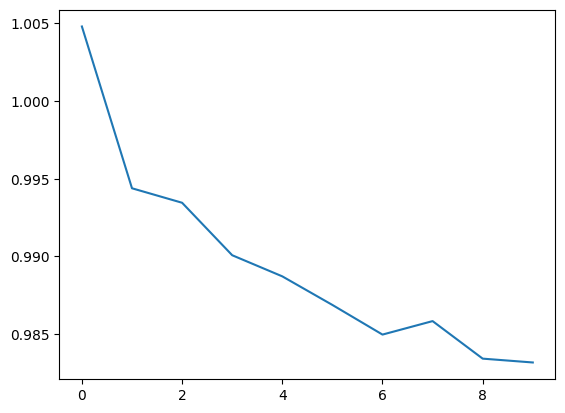

In [26]:
num_epochs = 10
loss_evolution = []

for epoch in range(1, num_epochs + 1):
    loss = train(model, loss_func, mining_func, train_loader, optimizer, epoch)
    loss_evolution.append(loss)
    test(train_dataset, test_dataset, model, accuracy_calculator)

plt.plot(loss_evolution)
plt.show()

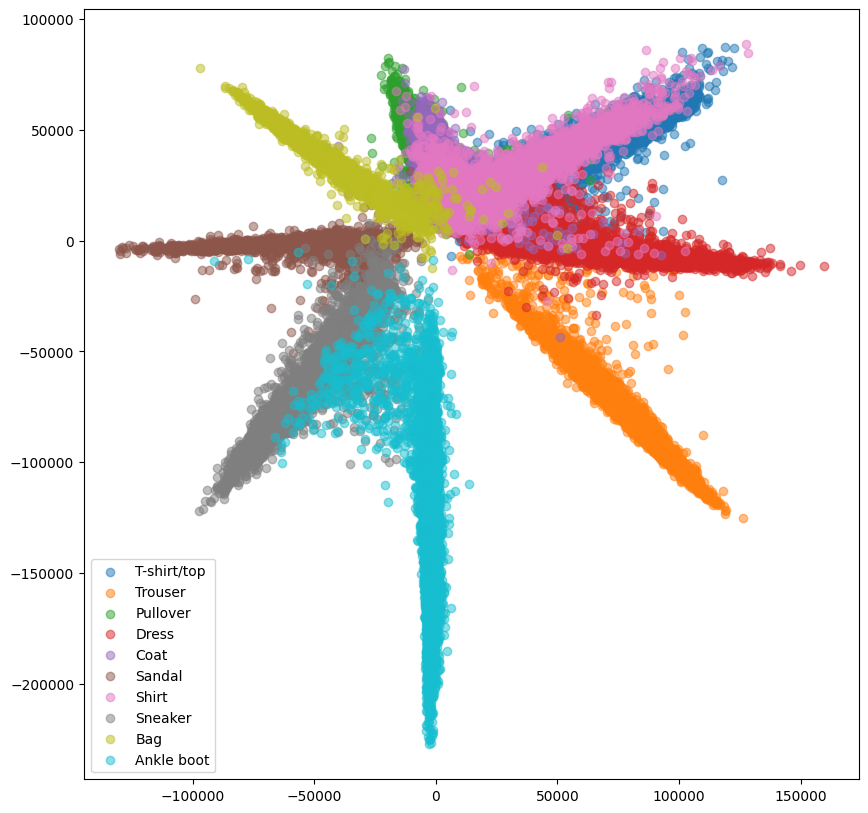

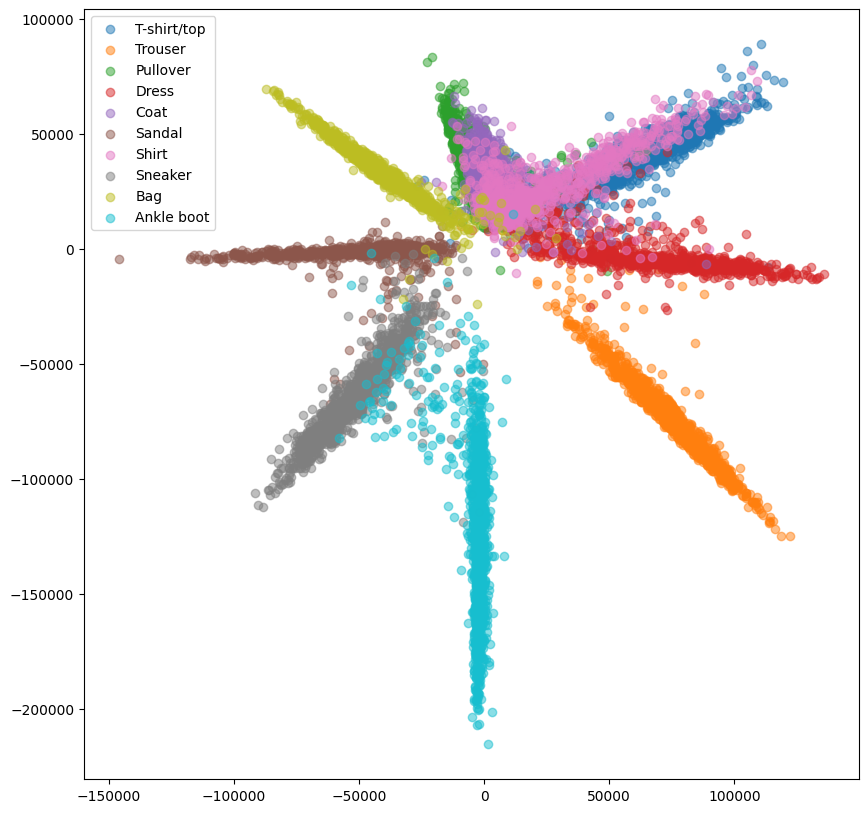

In [27]:
train_embeddings_baseline, train_labels_baseline = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_baseline, train_labels_baseline)
val_embeddings_baseline, val_labels_baseline = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_baseline, val_labels_baseline)

## Better Mining

<br>
<span style="color:blue">

**Exercise 1**: Explain the difference between semi-hard, easy and hard triplets. Try training with each type of triplets mentioned above separately and comment on the effect they have on training, using loss curves and other evidence you find necessary.
    
</span>

---
In triplet learning, we use three images or data points: an anchor (A), a positive (P), which is similar to the anchor, and a negative (N), which is different. The goal is to train the model so that it sees the anchor and positive as close, and the anchor and negative as far apart. Based on how the model handles this, triplets can be grouped into easy, hard, or semi-hard categories.

Easy triplets are cases where the model already understands the difference well. It clearly places the anchor close to the positive and far from the negative, even more than what is required. Because the model is already doing a good job with these, they don’t help much in improving the learning. Including too many easy triplets can slow down training because the model isn’t learning anything new from them.

Hard triplets are the opposite. These are difficult for the model because it mistakenly places the negative closer to the anchor than the positive. This can confuse the model and cause unstable or poor learning, especially in the early stages of training. If the model sees too many hard examples too soon, it might struggle to learn properly.

Semi-hard triplets are in between. In these examples, the model does place the positive closer to the anchor than the negative, but not by enough distance. These are the most helpful for training. They show the model that it's going in the right direction, but still needs improvement. That’s why semi-hard triplets are usually preferred—they help the model learn effectively and steadily without being too easy or too difficult.


---


In [28]:
#Your Code Here
# List of triplet types we want to test in order to prove the answer
triplet_types = ["easy", "hard", "semihard"]
loss_dict = {}

for triplet_type in triplet_types:
    print(f"\nTraining with {triplet_type} triplets...")

    # Choose how to pick triplets (based on current type)
    mining_func = miners.TripletMarginMiner(margin=0.2, distance=distance, type_of_triplets=triplet_type)

    # Start fresh with a new model and optimizer each time
    model = EmbeddingNet().to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    # Save the loss after each training round (epoch)
    loss_evolution = []

    for epoch in range(1, 5):
        # Train the model and get the loss
        loss = train(model, loss_func, mining_func, train_loader, optimizer, epoch)
        loss_evolution.append(loss)

        # Check how well the model is doing
        test(train_dataset, test_dataset, model, accuracy_calculator)

    # Store the loss trend for this type of triplet
    loss_dict[triplet_type] = loss_evolution



Training with easy triplets...
Epoch 1 Iteration 0: Loss = 0.7415803670883179, Number of mined triplets = 21781
Epoch 1 Iteration 20: Loss = 0.4335750937461853, Number of mined triplets = 784544
Epoch 1 Iteration 40: Loss = 0.4155462682247162, Number of mined triplets = 991676
Epoch 1 Iteration 60: Loss = 0.3941192328929901, Number of mined triplets = 1060992
Epoch 1 Iteration 80: Loss = 0.38797271251678467, Number of mined triplets = 1081302
Epoch 1 Iteration 100: Loss = 0.32442790269851685, Number of mined triplets = 1096864
Epoch 1 Iteration 120: Loss = 0.2355337142944336, Number of mined triplets = 1092753
Epoch 1 Iteration 140: Loss = 0.23101221024990082, Number of mined triplets = 1117251
Epoch 1 Iteration 160: Loss = 0.31343409419059753, Number of mined triplets = 1057287
Epoch 1 Iteration 180: Loss = 0.13390669226646423, Number of mined triplets = 1068743
Epoch 1 Iteration 200: Loss = 0.20045053958892822, Number of mined triplets = 1078334
Epoch 1 Iteration 220: Loss = 0.19304

100%|██████████| 313/313 [00:02<00:00, 138.47it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.4140166666666667
Epoch 2 Iteration 0: Loss = 0.07739235460758209, Number of mined triplets = 1081108
Epoch 2 Iteration 20: Loss = 0.12621323764324188, Number of mined triplets = 1111046
Epoch 2 Iteration 40: Loss = 0.09024898707866669, Number of mined triplets = 1053220
Epoch 2 Iteration 60: Loss = 0.0632082000374794, Number of mined triplets = 1090031
Epoch 2 Iteration 80: Loss = 0.17751500010490417, Number of mined triplets = 1064870
Epoch 2 Iteration 100: Loss = 0.07727181166410446, Number of mined triplets = 1096482
Epoch 2 Iteration 120: Loss = 0.048380590975284576, Number of mined triplets = 1085250
Epoch 2 Iteration 140: Loss = 0.07684125751256943, Number of mined triplets = 1075577
Epoch 2 Iteration 160: Loss = 0.05816737189888954, Number of mined triplets = 1056626
Epoch 2 Iteration 180: Loss = 0.09552056342363358, Number of mined triplets = 1058305
Epoch 2 Iteration 200: Loss = 0.06668310612440109, Number of mined triplet

100%|██████████| 313/313 [00:02<00:00, 110.06it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.43610000000000004
Epoch 3 Iteration 0: Loss = 0.042512018233537674, Number of mined triplets = 1080143
Epoch 3 Iteration 20: Loss = 0.13028182089328766, Number of mined triplets = 1016942
Epoch 3 Iteration 40: Loss = 0.1672697365283966, Number of mined triplets = 1117472
Epoch 3 Iteration 60: Loss = 0.05431879311800003, Number of mined triplets = 1077482
Epoch 3 Iteration 80: Loss = 0.09772040694952011, Number of mined triplets = 1102577
Epoch 3 Iteration 100: Loss = 0.04301181063055992, Number of mined triplets = 1076199
Epoch 3 Iteration 120: Loss = 0.02278900519013405, Number of mined triplets = 1035331
Epoch 3 Iteration 140: Loss = 0.06441369652748108, Number of mined triplets = 1020326
Epoch 3 Iteration 160: Loss = 0.023630287498235703, Number of mined triplets = 1129976
Epoch 3 Iteration 180: Loss = 0.028143106028437614, Number of mined triplets = 1067558
Epoch 3 Iteration 200: Loss = 0.050937552005052567, Number of mined tri

100%|██████████| 313/313 [00:02<00:00, 134.53it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.40581666666666666
Epoch 4 Iteration 0: Loss = 0.029717743396759033, Number of mined triplets = 1054574
Epoch 4 Iteration 20: Loss = 0.07282796502113342, Number of mined triplets = 1085612
Epoch 4 Iteration 40: Loss = 0.0203113816678524, Number of mined triplets = 1077509
Epoch 4 Iteration 60: Loss = 0.02469601109623909, Number of mined triplets = 1122901
Epoch 4 Iteration 80: Loss = 0.015943393111228943, Number of mined triplets = 1099476
Epoch 4 Iteration 100: Loss = 0.014197696931660175, Number of mined triplets = 1156552
Epoch 4 Iteration 120: Loss = 0.0663599893450737, Number of mined triplets = 1031276
Epoch 4 Iteration 140: Loss = 0.056529171764850616, Number of mined triplets = 1082263
Epoch 4 Iteration 160: Loss = 0.017105339094996452, Number of mined triplets = 1072123
Epoch 4 Iteration 180: Loss = 0.00831635668873787, Number of mined triplets = 1128012
Epoch 4 Iteration 200: Loss = 0.024933621287345886, Number of mined tr

100%|██████████| 313/313 [00:02<00:00, 122.47it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.4543666666666667

Training with hard triplets...
Epoch 1 Iteration 0: Loss = 1.0112698078155518, Number of mined triplets = 580110
Epoch 1 Iteration 20: Loss = 1.0000022649765015, Number of mined triplets = 587557
Epoch 1 Iteration 40: Loss = 1.0000252723693848, Number of mined triplets = 564514
Epoch 1 Iteration 60: Loss = 1.0000051259994507, Number of mined triplets = 556148
Epoch 1 Iteration 80: Loss = 1.0000004768371582, Number of mined triplets = 587154
Epoch 1 Iteration 100: Loss = 1.000000238418579, Number of mined triplets = 618762
Epoch 1 Iteration 120: Loss = 1.000000238418579, Number of mined triplets = 588901
Epoch 1 Iteration 140: Loss = 1.000000238418579, Number of mined triplets = 617185
Epoch 1 Iteration 160: Loss = 1.0000001192092896, Number of mined triplets = 588633
Epoch 1 Iteration 180: Loss = 1.000000238418579, Number of mined triplets = 632119
Epoch 1 Iteration 200: Loss = 1.0000001192092896, Number of mined 

100%|██████████| 313/313 [00:02<00:00, 135.15it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.18205000000000002
Epoch 2 Iteration 0: Loss = 1.000000238418579, Number of mined triplets = 586852
Epoch 2 Iteration 20: Loss = 1.000000238418579, Number of mined triplets = 673433
Epoch 2 Iteration 40: Loss = 0.9999999403953552, Number of mined triplets = 569709
Epoch 2 Iteration 60: Loss = 1.000000238418579, Number of mined triplets = 609525
Epoch 2 Iteration 80: Loss = 1.000000238418579, Number of mined triplets = 647001
Epoch 2 Iteration 100: Loss = 1.000000238418579, Number of mined triplets = 593504
Epoch 2 Iteration 120: Loss = 1.000000238418579, Number of mined triplets = 657170
Epoch 2 Iteration 140: Loss = 1.0000001192092896, Number of mined triplets = 619146
Epoch 2 Iteration 160: Loss = 1.0000001192092896, Number of mined triplets = 639685
Epoch 2 Iteration 180: Loss = 1.0, Number of mined triplets = 605793
Epoch 2 Iteration 200: Loss = 1.0, Number of mined triplets = 611312
Epoch 2 Iteration 220: Loss = 1.0, Number of 

100%|██████████| 313/313 [00:03<00:00, 97.21it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.1774
Epoch 3 Iteration 0: Loss = 1.0000001192092896, Number of mined triplets = 646412
Epoch 3 Iteration 20: Loss = 1.0, Number of mined triplets = 611792
Epoch 3 Iteration 40: Loss = 1.0, Number of mined triplets = 708106
Epoch 3 Iteration 60: Loss = 1.0, Number of mined triplets = 580974
Epoch 3 Iteration 80: Loss = 1.0, Number of mined triplets = 651136
Epoch 3 Iteration 100: Loss = 1.0, Number of mined triplets = 625116
Epoch 3 Iteration 120: Loss = 1.0, Number of mined triplets = 636578
Epoch 3 Iteration 140: Loss = 1.0, Number of mined triplets = 647343
Epoch 3 Iteration 160: Loss = 1.0, Number of mined triplets = 671332
Epoch 3 Iteration 180: Loss = 1.0, Number of mined triplets = 688123
Epoch 3 Iteration 200: Loss = 0.9999999403953552, Number of mined triplets = 638002
Epoch 3 Iteration 220: Loss = 1.0, Number of mined triplets = 667869


100%|██████████| 313/313 [00:02<00:00, 135.23it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.18653333333333333
Epoch 4 Iteration 0: Loss = 1.0, Number of mined triplets = 731199
Epoch 4 Iteration 20: Loss = 1.0, Number of mined triplets = 683405
Epoch 4 Iteration 40: Loss = 1.0, Number of mined triplets = 709356
Epoch 4 Iteration 60: Loss = 1.0, Number of mined triplets = 628171
Epoch 4 Iteration 80: Loss = 1.0, Number of mined triplets = 701529
Epoch 4 Iteration 100: Loss = 0.9999999403953552, Number of mined triplets = 648232
Epoch 4 Iteration 120: Loss = 1.0, Number of mined triplets = 708406
Epoch 4 Iteration 140: Loss = 0.9999999403953552, Number of mined triplets = 647540
Epoch 4 Iteration 160: Loss = 0.9999999403953552, Number of mined triplets = 656271
Epoch 4 Iteration 180: Loss = 1.0, Number of mined triplets = 640508
Epoch 4 Iteration 200: Loss = 1.0, Number of mined triplets = 702579
Epoch 4 Iteration 220: Loss = 1.0, Number of mined triplets = 793229


100%|██████████| 313/313 [00:02<00:00, 130.70it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.14821666666666666

Training with semihard triplets...
Epoch 1 Iteration 0: Loss = 0.9456409215927124, Number of mined triplets = 864182
Epoch 1 Iteration 20: Loss = 0.9149737358093262, Number of mined triplets = 156762
Epoch 1 Iteration 40: Loss = 0.915026068687439, Number of mined triplets = 173348
Epoch 1 Iteration 60: Loss = 0.917732298374176, Number of mined triplets = 130924
Epoch 1 Iteration 80: Loss = 0.9046841263771057, Number of mined triplets = 140946
Epoch 1 Iteration 100: Loss = 0.9034315347671509, Number of mined triplets = 146155
Epoch 1 Iteration 120: Loss = 0.9030178189277649, Number of mined triplets = 152401
Epoch 1 Iteration 140: Loss = 0.8989351391792297, Number of mined triplets = 134045
Epoch 1 Iteration 160: Loss = 0.9105084538459778, Number of mined triplets = 158860
Epoch 1 Iteration 180: Loss = 0.8935938477516174, Number of mined triplets = 139059
Epoch 1 Iteration 200: Loss = 0.8852912783622742, Number of

100%|██████████| 313/313 [00:02<00:00, 137.18it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.6860666666666667
Epoch 2 Iteration 0: Loss = 0.8806167840957642, Number of mined triplets = 177170
Epoch 2 Iteration 20: Loss = 0.8911755084991455, Number of mined triplets = 158978
Epoch 2 Iteration 40: Loss = 0.8992455005645752, Number of mined triplets = 172237
Epoch 2 Iteration 60: Loss = 0.8883458375930786, Number of mined triplets = 150324
Epoch 2 Iteration 80: Loss = 0.8916319608688354, Number of mined triplets = 137152
Epoch 2 Iteration 100: Loss = 0.9010935425758362, Number of mined triplets = 120795
Epoch 2 Iteration 120: Loss = 0.8818209171295166, Number of mined triplets = 160847
Epoch 2 Iteration 140: Loss = 0.8929516077041626, Number of mined triplets = 163500
Epoch 2 Iteration 160: Loss = 0.8736863732337952, Number of mined triplets = 153251
Epoch 2 Iteration 180: Loss = 0.9087724685668945, Number of mined triplets = 154173
Epoch 2 Iteration 200: Loss = 0.8787285685539246, Number of mined triplets = 122916
Epoch 2 It

100%|██████████| 313/313 [00:02<00:00, 138.03it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.7396
Epoch 3 Iteration 0: Loss = 0.8937079906463623, Number of mined triplets = 177592
Epoch 3 Iteration 20: Loss = 0.8721950054168701, Number of mined triplets = 123546
Epoch 3 Iteration 40: Loss = 0.8911982178688049, Number of mined triplets = 131093
Epoch 3 Iteration 60: Loss = 0.8718616962432861, Number of mined triplets = 150393
Epoch 3 Iteration 80: Loss = 0.8859357833862305, Number of mined triplets = 121374
Epoch 3 Iteration 100: Loss = 0.8864099383354187, Number of mined triplets = 129866
Epoch 3 Iteration 120: Loss = 0.875973641872406, Number of mined triplets = 131311
Epoch 3 Iteration 140: Loss = 0.8822286128997803, Number of mined triplets = 159373
Epoch 3 Iteration 160: Loss = 0.8908512592315674, Number of mined triplets = 124546
Epoch 3 Iteration 180: Loss = 0.882619321346283, Number of mined triplets = 144784
Epoch 3 Iteration 200: Loss = 0.897195041179657, Number of mined triplets = 103809
Epoch 3 Iteration 220: Lo

100%|██████████| 313/313 [00:02<00:00, 110.24it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.766
Epoch 4 Iteration 0: Loss = 0.8856924176216125, Number of mined triplets = 141448
Epoch 4 Iteration 20: Loss = 0.8695929646492004, Number of mined triplets = 138966
Epoch 4 Iteration 40: Loss = 0.8699278235435486, Number of mined triplets = 147811
Epoch 4 Iteration 60: Loss = 0.8884087800979614, Number of mined triplets = 107918
Epoch 4 Iteration 80: Loss = 0.8683897852897644, Number of mined triplets = 147271
Epoch 4 Iteration 100: Loss = 0.8874561786651611, Number of mined triplets = 138972
Epoch 4 Iteration 120: Loss = 0.8786466717720032, Number of mined triplets = 119301
Epoch 4 Iteration 140: Loss = 0.8666564226150513, Number of mined triplets = 141850
Epoch 4 Iteration 160: Loss = 0.8856955170631409, Number of mined triplets = 108196
Epoch 4 Iteration 180: Loss = 0.889103889465332, Number of mined triplets = 112001
Epoch 4 Iteration 200: Loss = 0.876210629940033, Number of mined triplets = 128009
Epoch 4 Iteration 220: Lo

100%|██████████| 313/313 [00:02<00:00, 133.65it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.7248333333333333


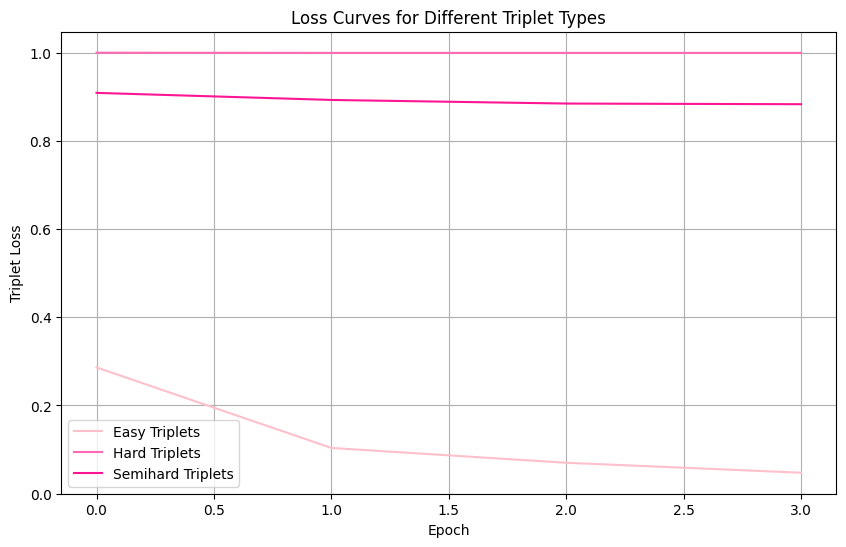

In [32]:
colors = {"easy": "#FFC0CB","hard": "#FF69B4","semihard": "#FF1493"}

plt.figure(figsize=(10, 6))

for triplet_type in triplet_types:
    plt.plot(loss_dict[triplet_type], label=f"{triplet_type.capitalize()} Triplets", color=colors[triplet_type])

plt.xlabel("Epoch")
plt.ylabel("Triplet Loss")
plt.title("Loss Curves for Different Triplet Types")
plt.legend()
plt.grid(True)
plt.show()


---
Easy triplets show low and slowly decreasing loss, meaning the model isn’t learning much new. Accuracy may improve early but then levels off. Hard triplets often result in high, unstable loss and can confuse the model, leading to poor or inconsistent accuracy. Semi-hard triplets provide the best learning: the loss decreases steadily, and accuracy gradually improves, often reaching the highest levels. This makes semi-hard triplets the most effective and balanced choice for training.

---

<br>
<span style="color:blue">

**Exercise 2**: Read the documentation of the PyTorch Metric Learning library and try a couple of different mining strategies, distances, margins and loss functions.
    
</span>


---

In this experiment, we explored various configurations using the PyTorch Metric Learning library to better understand how different components affect model training. We tested multiple **mining strategies**, including `MultiSimilarityMiner` and `PairMarginMiner`, to select the most informative pairs or triplets for learning. For **distance metrics**, we compared `CosineSimilarity`, `Euclidean (LpDistance p=2)`, and `Manhattan (LpDistance p=1)` to see how they influence embedding space. We also experimented with different **triplet margin values** (0.2, 0.5, and 1.0) to adjust how strongly the model separates positive and negative samples. Lastly, we evaluated different **loss functions** such as `TripletMarginLoss`, `ContrastiveLoss`, `NTXentLoss`, and `MultiSimilarityLoss`, each offering unique ways of shaping the embeddings. This variety allowed us to assess how each combination impacts training effectiveness and stability.

---

In [33]:
# Your Code Here
# Mining Strategies
miner = miners.MultiSimilarityMiner(epsilon=0.1)
miner = miners.PairMarginMiner(pos_margin=0.8, neg_margin=1.2)

# Distances
distance = distances.CosineSimilarity()
distance = distances.LpDistance(p=2)  # Euclidean
distance = distances.LpDistance(p=1)  # Manhattan

# Margins
loss_func = losses.TripletMarginLoss(margin=0.2)
loss_func = losses.TripletMarginLoss(margin=0.5)
loss_func = losses.TripletMarginLoss(margin=1)


# Loss Functions
loss_func = losses.ContrastiveLoss(pos_margin=0, neg_margin=1)
loss_func = losses.NTXentLoss(temperature=0.07)
loss_func = losses.MultiSimilarityLoss(alpha=2, beta=50, base=0.5)

def train(model, loss_func, mining_func, train_loader, optimizer, epoch):
    model.train()
    total_loss = 0
    for batch_idx, (data, labels) in enumerate(train_loader):
        data, labels = data.cuda(), labels.cuda()
        embeddings = model(data)
        indices = mining_func(embeddings, labels)
        loss = loss_func(embeddings, labels, indices)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch_idx % 20 == 0:
            print("Epoch {} Iteration {}: Loss = {}, Number of mined triplets = {}".format(epoch, batch_idx, loss, len(indices))) # Changed line
    return total_loss / (batch_idx + 1)

In [34]:
from pytorch_metric_learning import losses, miners, distances
import torch.optim as optim

# Define different loss setups
experiments = {
    "MultiSimilarityLoss": {
        "loss_func": losses.MultiSimilarityLoss(alpha=2, beta=50, base=0.5),
        "miner": miners.MultiSimilarityMiner(epsilon=0.1),
        "distance": distances.LpDistance(p=2)
    },
    "NTXentLoss": {
        "loss_func": losses.NTXentLoss(temperature=0.07),
        "miner": miners.PairMarginMiner(pos_margin=0.8, neg_margin=1.2),
        "distance": distances.CosineSimilarity()
    },
    "ContrastiveLoss": {
        "loss_func": losses.ContrastiveLoss(pos_margin=0, neg_margin=1),
        "miner": miners.PairMarginMiner(pos_margin=0.8, neg_margin=1.2),
        "distance": distances.LpDistance(p=1)
    },
    "TripletMarginLoss_0.2": {
        "loss_func": losses.TripletMarginLoss(margin=0.2),
        "miner": miners.TripletMarginMiner(margin=0.2, distance=distances.LpDistance(p=2), type_of_triplets="semihard"),
        "distance": distances.LpDistance(p=2)
    },
    "TripletMarginLoss_1.0": {
        "loss_func": losses.TripletMarginLoss(margin=1.0),
        "miner": miners.TripletMarginMiner(margin=1.0, distance=distances.LpDistance(p=2), type_of_triplets="semihard"),
        "distance": distances.LpDistance(p=2)
    }
}

# Store the loss evolution for each experiment
all_losses = {}

# Training loop for each loss setup
for name, config in experiments.items():
    print(f"\nRunning experiment with {name}...")

    model = EmbeddingNet().to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    loss_func = config["loss_func"]
    mining_func = config["miner"]

    loss_evolution = []
    for epoch in range(1, 5):
        loss = train(model, loss_func, mining_func, train_loader, optimizer, epoch)
        loss_evolution.append(loss)
        test(train_dataset, test_dataset, model, accuracy_calculator)

    all_losses[name] = loss_evolution



Running experiment with MultiSimilarityLoss...
Epoch 1 Iteration 0: Loss = 1.7716684341430664, Number of mined triplets = 4
Epoch 1 Iteration 20: Loss = 1.745708703994751, Number of mined triplets = 4
Epoch 1 Iteration 40: Loss = 1.7421541213989258, Number of mined triplets = 4
Epoch 1 Iteration 60: Loss = 1.750001072883606, Number of mined triplets = 4
Epoch 1 Iteration 80: Loss = 1.7353768348693848, Number of mined triplets = 4
Epoch 1 Iteration 100: Loss = 1.7428548336029053, Number of mined triplets = 4
Epoch 1 Iteration 120: Loss = 1.70003080368042, Number of mined triplets = 4
Epoch 1 Iteration 140: Loss = 1.7129731178283691, Number of mined triplets = 4
Epoch 1 Iteration 160: Loss = 1.6789445877075195, Number of mined triplets = 4
Epoch 1 Iteration 180: Loss = 1.7322629690170288, Number of mined triplets = 4
Epoch 1 Iteration 200: Loss = 1.6802524328231812, Number of mined triplets = 4
Epoch 1 Iteration 220: Loss = 1.6784662008285522, Number of mined triplets = 4


100%|██████████| 313/313 [00:02<00:00, 119.86it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.5950166666666667
Epoch 2 Iteration 0: Loss = 1.7278320789337158, Number of mined triplets = 4
Epoch 2 Iteration 20: Loss = 1.6936217546463013, Number of mined triplets = 4
Epoch 2 Iteration 40: Loss = 1.7299467325210571, Number of mined triplets = 4
Epoch 2 Iteration 60: Loss = 1.741833209991455, Number of mined triplets = 4
Epoch 2 Iteration 80: Loss = 1.7071893215179443, Number of mined triplets = 4
Epoch 2 Iteration 100: Loss = 1.6286919116973877, Number of mined triplets = 4
Epoch 2 Iteration 120: Loss = 1.6708297729492188, Number of mined triplets = 4
Epoch 2 Iteration 140: Loss = 1.6933367252349854, Number of mined triplets = 4
Epoch 2 Iteration 160: Loss = 1.737494707107544, Number of mined triplets = 4
Epoch 2 Iteration 180: Loss = 1.7320619821548462, Number of mined triplets = 4
Epoch 2 Iteration 200: Loss = 1.6393098831176758, Number of mined triplets = 4
Epoch 2 Iteration 220: Loss = 1.6387596130371094, Number of mined t

100%|██████████| 313/313 [00:02<00:00, 137.57it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.6223833333333334
Epoch 3 Iteration 0: Loss = 1.6931757926940918, Number of mined triplets = 4
Epoch 3 Iteration 20: Loss = 1.6614254713058472, Number of mined triplets = 4
Epoch 3 Iteration 40: Loss = 1.667183756828308, Number of mined triplets = 4
Epoch 3 Iteration 60: Loss = 1.7517354488372803, Number of mined triplets = 4
Epoch 3 Iteration 80: Loss = 1.7470934391021729, Number of mined triplets = 4
Epoch 3 Iteration 100: Loss = 1.7435433864593506, Number of mined triplets = 4
Epoch 3 Iteration 120: Loss = 1.7379977703094482, Number of mined triplets = 4
Epoch 3 Iteration 140: Loss = 1.7342100143432617, Number of mined triplets = 4
Epoch 3 Iteration 160: Loss = 1.7267709970474243, Number of mined triplets = 4
Epoch 3 Iteration 180: Loss = 1.7317063808441162, Number of mined triplets = 4
Epoch 3 Iteration 200: Loss = 1.761772871017456, Number of mined triplets = 4
Epoch 3 Iteration 220: Loss = 1.64556884765625, Number of mined tri

100%|██████████| 313/313 [00:03<00:00, 99.70it/s] 


Computing accuracy
Test set accuracy (Precision@1) = 0.6285166666666667
Epoch 4 Iteration 0: Loss = 1.6370471715927124, Number of mined triplets = 4
Epoch 4 Iteration 20: Loss = 1.7932041883468628, Number of mined triplets = 4
Epoch 4 Iteration 40: Loss = 1.7558218240737915, Number of mined triplets = 4
Epoch 4 Iteration 60: Loss = 1.7557369470596313, Number of mined triplets = 4
Epoch 4 Iteration 80: Loss = 1.7554813623428345, Number of mined triplets = 4
Epoch 4 Iteration 100: Loss = 1.7450766563415527, Number of mined triplets = 4
Epoch 4 Iteration 120: Loss = 1.7503297328948975, Number of mined triplets = 4
Epoch 4 Iteration 140: Loss = 1.742158055305481, Number of mined triplets = 4
Epoch 4 Iteration 160: Loss = 1.7292791604995728, Number of mined triplets = 4
Epoch 4 Iteration 180: Loss = 1.7130025625228882, Number of mined triplets = 4
Epoch 4 Iteration 200: Loss = 1.7344779968261719, Number of mined triplets = 4
Epoch 4 Iteration 220: Loss = 1.6916288137435913, Number of mined 

100%|██████████| 313/313 [00:02<00:00, 136.79it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.5760000000000001

Running experiment with NTXentLoss...
Epoch 1 Iteration 0: Loss = 0.0, Number of mined triplets = 4
Epoch 1 Iteration 20: Loss = 0.0, Number of mined triplets = 4
Epoch 1 Iteration 40: Loss = 0.0, Number of mined triplets = 4
Epoch 1 Iteration 60: Loss = 0.0, Number of mined triplets = 4
Epoch 1 Iteration 80: Loss = 0.0, Number of mined triplets = 4
Epoch 1 Iteration 100: Loss = 0.0, Number of mined triplets = 4
Epoch 1 Iteration 120: Loss = 0.0, Number of mined triplets = 4
Epoch 1 Iteration 140: Loss = 0.0, Number of mined triplets = 4
Epoch 1 Iteration 160: Loss = 0.0, Number of mined triplets = 4
Epoch 1 Iteration 180: Loss = 0.0, Number of mined triplets = 4
Epoch 1 Iteration 200: Loss = 0.0, Number of mined triplets = 4
Epoch 1 Iteration 220: Loss = 0.0, Number of mined triplets = 4


100%|██████████| 313/313 [00:02<00:00, 105.75it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.19773333333333334
Epoch 2 Iteration 0: Loss = 0.0, Number of mined triplets = 4
Epoch 2 Iteration 20: Loss = 0.0, Number of mined triplets = 4
Epoch 2 Iteration 40: Loss = 0.0, Number of mined triplets = 4
Epoch 2 Iteration 60: Loss = 0.0, Number of mined triplets = 4
Epoch 2 Iteration 80: Loss = 0.0, Number of mined triplets = 4
Epoch 2 Iteration 100: Loss = 0.0, Number of mined triplets = 4
Epoch 2 Iteration 120: Loss = 0.0, Number of mined triplets = 4
Epoch 2 Iteration 140: Loss = 0.0, Number of mined triplets = 4
Epoch 2 Iteration 160: Loss = 0.0, Number of mined triplets = 4
Epoch 2 Iteration 180: Loss = 0.0, Number of mined triplets = 4
Epoch 2 Iteration 200: Loss = 0.0, Number of mined triplets = 4
Epoch 2 Iteration 220: Loss = 0.0, Number of mined triplets = 4


100%|██████████| 313/313 [00:02<00:00, 136.21it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.19773333333333334
Epoch 3 Iteration 0: Loss = 0.0, Number of mined triplets = 4
Epoch 3 Iteration 20: Loss = 0.0, Number of mined triplets = 4
Epoch 3 Iteration 40: Loss = 0.0, Number of mined triplets = 4
Epoch 3 Iteration 60: Loss = 0.0, Number of mined triplets = 4
Epoch 3 Iteration 80: Loss = 0.0, Number of mined triplets = 4
Epoch 3 Iteration 100: Loss = 0.0, Number of mined triplets = 4
Epoch 3 Iteration 120: Loss = 0.0, Number of mined triplets = 4
Epoch 3 Iteration 140: Loss = 0.0, Number of mined triplets = 4
Epoch 3 Iteration 160: Loss = 0.0, Number of mined triplets = 4
Epoch 3 Iteration 180: Loss = 0.0, Number of mined triplets = 4
Epoch 3 Iteration 200: Loss = 0.0, Number of mined triplets = 4
Epoch 3 Iteration 220: Loss = 0.0, Number of mined triplets = 4


100%|██████████| 313/313 [00:02<00:00, 140.06it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.19773333333333334
Epoch 4 Iteration 0: Loss = 0.0, Number of mined triplets = 4
Epoch 4 Iteration 20: Loss = 0.0, Number of mined triplets = 4
Epoch 4 Iteration 40: Loss = 0.0, Number of mined triplets = 4
Epoch 4 Iteration 60: Loss = 0.0, Number of mined triplets = 4
Epoch 4 Iteration 80: Loss = 0.0, Number of mined triplets = 4
Epoch 4 Iteration 100: Loss = 0.0, Number of mined triplets = 4
Epoch 4 Iteration 120: Loss = 0.0, Number of mined triplets = 4
Epoch 4 Iteration 140: Loss = 0.0, Number of mined triplets = 4
Epoch 4 Iteration 160: Loss = 0.0, Number of mined triplets = 4
Epoch 4 Iteration 180: Loss = 0.0, Number of mined triplets = 4
Epoch 4 Iteration 200: Loss = 0.0, Number of mined triplets = 4
Epoch 4 Iteration 220: Loss = 0.0, Number of mined triplets = 4


100%|██████████| 313/313 [00:03<00:00, 101.92it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.19773333333333334

Running experiment with ContrastiveLoss...
Epoch 1 Iteration 0: Loss = 0.8337050080299377, Number of mined triplets = 4
Epoch 1 Iteration 20: Loss = 0.7213237285614014, Number of mined triplets = 4
Epoch 1 Iteration 40: Loss = 0.6858692169189453, Number of mined triplets = 4
Epoch 1 Iteration 60: Loss = 1.403892993927002, Number of mined triplets = 4
Epoch 1 Iteration 80: Loss = 0.6047514081001282, Number of mined triplets = 4
Epoch 1 Iteration 100: Loss = 1.3734495639801025, Number of mined triplets = 4
Epoch 1 Iteration 120: Loss = 0.5892198085784912, Number of mined triplets = 4
Epoch 1 Iteration 140: Loss = 0.7390710711479187, Number of mined triplets = 4
Epoch 1 Iteration 160: Loss = 0.5736146569252014, Number of mined triplets = 4
Epoch 1 Iteration 180: Loss = 0.5797340273857117, Number of mined triplets = 4
Epoch 1 Iteration 200: Loss = 1.4036712646484375, Number of mined triplets = 4
Epoch 1 Iteration 220

100%|██████████| 313/313 [00:02<00:00, 142.95it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.3845166666666667
Epoch 2 Iteration 0: Loss = 0.5587287545204163, Number of mined triplets = 4
Epoch 2 Iteration 20: Loss = 1.5880327224731445, Number of mined triplets = 4
Epoch 2 Iteration 40: Loss = 1.387619972229004, Number of mined triplets = 4
Epoch 2 Iteration 60: Loss = 1.4178410768508911, Number of mined triplets = 4
Epoch 2 Iteration 80: Loss = 1.3412516117095947, Number of mined triplets = 4
Epoch 2 Iteration 100: Loss = 1.390043020248413, Number of mined triplets = 4
Epoch 2 Iteration 120: Loss = 1.4508144855499268, Number of mined triplets = 4
Epoch 2 Iteration 140: Loss = 1.3831779956817627, Number of mined triplets = 4
Epoch 2 Iteration 160: Loss = 1.3917948007583618, Number of mined triplets = 4
Epoch 2 Iteration 180: Loss = 0.525840699672699, Number of mined triplets = 4
Epoch 2 Iteration 200: Loss = 0.5850433707237244, Number of mined triplets = 4
Epoch 2 Iteration 220: Loss = 1.359490156173706, Number of mined tri

100%|██████████| 313/313 [00:02<00:00, 142.31it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.4673333333333334
Epoch 3 Iteration 0: Loss = 0.5711892247200012, Number of mined triplets = 4
Epoch 3 Iteration 20: Loss = 0.521409809589386, Number of mined triplets = 4
Epoch 3 Iteration 40: Loss = 1.3770227432250977, Number of mined triplets = 4
Epoch 3 Iteration 60: Loss = 0.6091032028198242, Number of mined triplets = 4
Epoch 3 Iteration 80: Loss = 0.5458701252937317, Number of mined triplets = 4
Epoch 3 Iteration 100: Loss = 0.5338361859321594, Number of mined triplets = 4
Epoch 3 Iteration 120: Loss = 1.3394889831542969, Number of mined triplets = 4
Epoch 3 Iteration 140: Loss = 0.6021571755409241, Number of mined triplets = 4
Epoch 3 Iteration 160: Loss = 1.3631072044372559, Number of mined triplets = 4
Epoch 3 Iteration 180: Loss = 0.5631811022758484, Number of mined triplets = 4
Epoch 3 Iteration 200: Loss = 0.5408932566642761, Number of mined triplets = 4
Epoch 3 Iteration 220: Loss = 1.3791881799697876, Number of mined 

100%|██████████| 313/313 [00:02<00:00, 113.19it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.49128333333333335
Epoch 4 Iteration 0: Loss = 1.4127955436706543, Number of mined triplets = 4
Epoch 4 Iteration 20: Loss = 0.5420845150947571, Number of mined triplets = 4
Epoch 4 Iteration 40: Loss = 1.3980073928833008, Number of mined triplets = 4
Epoch 4 Iteration 60: Loss = 0.5392622351646423, Number of mined triplets = 4
Epoch 4 Iteration 80: Loss = 1.3830223083496094, Number of mined triplets = 4
Epoch 4 Iteration 100: Loss = 0.5409978628158569, Number of mined triplets = 4
Epoch 4 Iteration 120: Loss = 0.5224842429161072, Number of mined triplets = 4
Epoch 4 Iteration 140: Loss = 1.441477656364441, Number of mined triplets = 4
Epoch 4 Iteration 160: Loss = 1.4213213920593262, Number of mined triplets = 4
Epoch 4 Iteration 180: Loss = 1.361303687095642, Number of mined triplets = 4
Epoch 4 Iteration 200: Loss = 0.5144600868225098, Number of mined triplets = 4
Epoch 4 Iteration 220: Loss = 1.33543062210083, Number of mined tr

100%|██████████| 313/313 [00:02<00:00, 142.34it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.5228333333333334

Running experiment with TripletMarginLoss_0.2...
Epoch 1 Iteration 0: Loss = 0.10790602117776871, Number of mined triplets = 3
Epoch 1 Iteration 20: Loss = 0.10480085015296936, Number of mined triplets = 3
Epoch 1 Iteration 40: Loss = 0.10019775480031967, Number of mined triplets = 3
Epoch 1 Iteration 60: Loss = 0.09741155058145523, Number of mined triplets = 3
Epoch 1 Iteration 80: Loss = 0.10021889954805374, Number of mined triplets = 3
Epoch 1 Iteration 100: Loss = 0.09397738426923752, Number of mined triplets = 3
Epoch 1 Iteration 120: Loss = 0.09886416792869568, Number of mined triplets = 3
Epoch 1 Iteration 140: Loss = 0.09707393497228622, Number of mined triplets = 3
Epoch 1 Iteration 160: Loss = 0.09796994179487228, Number of mined triplets = 3
Epoch 1 Iteration 180: Loss = 0.09830570966005325, Number of mined triplets = 3
Epoch 1 Iteration 200: Loss = 0.09415632486343384, Number of mined triplets = 3
Epoc

100%|██████████| 313/313 [00:02<00:00, 111.58it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.7126166666666667
Epoch 2 Iteration 0: Loss = 0.09643358737230301, Number of mined triplets = 3
Epoch 2 Iteration 20: Loss = 0.10241897404193878, Number of mined triplets = 3
Epoch 2 Iteration 40: Loss = 0.09708616137504578, Number of mined triplets = 3
Epoch 2 Iteration 60: Loss = 0.09360818564891815, Number of mined triplets = 3
Epoch 2 Iteration 80: Loss = 0.09387347847223282, Number of mined triplets = 3
Epoch 2 Iteration 100: Loss = 0.09533990174531937, Number of mined triplets = 3
Epoch 2 Iteration 120: Loss = 0.10000362992286682, Number of mined triplets = 3
Epoch 2 Iteration 140: Loss = 0.09529252350330353, Number of mined triplets = 3
Epoch 2 Iteration 160: Loss = 0.09547603875398636, Number of mined triplets = 3
Epoch 2 Iteration 180: Loss = 0.09455254673957825, Number of mined triplets = 3
Epoch 2 Iteration 200: Loss = 0.0994897335767746, Number of mined triplets = 3
Epoch 2 Iteration 220: Loss = 0.09652528911828995, Numb

100%|██████████| 313/313 [00:02<00:00, 138.35it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.7407666666666667
Epoch 3 Iteration 0: Loss = 0.09428612142801285, Number of mined triplets = 3
Epoch 3 Iteration 20: Loss = 0.09609796106815338, Number of mined triplets = 3
Epoch 3 Iteration 40: Loss = 0.096644327044487, Number of mined triplets = 3
Epoch 3 Iteration 60: Loss = 0.09545820951461792, Number of mined triplets = 3
Epoch 3 Iteration 80: Loss = 0.09007340669631958, Number of mined triplets = 3
Epoch 3 Iteration 100: Loss = 0.09866917878389359, Number of mined triplets = 3
Epoch 3 Iteration 120: Loss = 0.09413951635360718, Number of mined triplets = 3
Epoch 3 Iteration 140: Loss = 0.10115856677293777, Number of mined triplets = 3
Epoch 3 Iteration 160: Loss = 0.09716228395700455, Number of mined triplets = 3
Epoch 3 Iteration 180: Loss = 0.09302239865064621, Number of mined triplets = 3
Epoch 3 Iteration 200: Loss = 0.09558728337287903, Number of mined triplets = 3
Epoch 3 Iteration 220: Loss = 0.09417399019002914, Numbe

100%|██████████| 313/313 [00:02<00:00, 137.88it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.7698666666666667
Epoch 4 Iteration 0: Loss = 0.09883959591388702, Number of mined triplets = 3
Epoch 4 Iteration 20: Loss = 0.09903960675001144, Number of mined triplets = 3
Epoch 4 Iteration 40: Loss = 0.10062577575445175, Number of mined triplets = 3
Epoch 4 Iteration 60: Loss = 0.09790872782468796, Number of mined triplets = 3
Epoch 4 Iteration 80: Loss = 0.09819083660840988, Number of mined triplets = 3
Epoch 4 Iteration 100: Loss = 0.10270664095878601, Number of mined triplets = 3
Epoch 4 Iteration 120: Loss = 0.09782563894987106, Number of mined triplets = 3
Epoch 4 Iteration 140: Loss = 0.10082811862230301, Number of mined triplets = 3
Epoch 4 Iteration 160: Loss = 0.10153935849666595, Number of mined triplets = 3
Epoch 4 Iteration 180: Loss = 0.09740310907363892, Number of mined triplets = 3
Epoch 4 Iteration 200: Loss = 0.10024923831224442, Number of mined triplets = 3
Epoch 4 Iteration 220: Loss = 0.09550418704748154, Num

100%|██████████| 313/313 [00:02<00:00, 134.30it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8048833333333334

Running experiment with TripletMarginLoss_1.0...
Epoch 1 Iteration 0: Loss = 0.7739335894584656, Number of mined triplets = 3
Epoch 1 Iteration 20: Loss = 0.5243690609931946, Number of mined triplets = 3
Epoch 1 Iteration 40: Loss = 0.48475584387779236, Number of mined triplets = 3
Epoch 1 Iteration 60: Loss = 0.5001078844070435, Number of mined triplets = 3
Epoch 1 Iteration 80: Loss = 0.4567059278488159, Number of mined triplets = 3
Epoch 1 Iteration 100: Loss = 0.44832783937454224, Number of mined triplets = 3
Epoch 1 Iteration 120: Loss = 0.43686074018478394, Number of mined triplets = 3
Epoch 1 Iteration 140: Loss = 0.40772193670272827, Number of mined triplets = 3
Epoch 1 Iteration 160: Loss = 0.4133772850036621, Number of mined triplets = 3
Epoch 1 Iteration 180: Loss = 0.41498932242393494, Number of mined triplets = 3
Epoch 1 Iteration 200: Loss = 0.37399452924728394, Number of mined triplets = 3
Epoch 1 I

100%|██████████| 313/313 [00:02<00:00, 139.33it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.6534833333333334
Epoch 2 Iteration 0: Loss = 0.39011380076408386, Number of mined triplets = 3
Epoch 2 Iteration 20: Loss = 0.41034409403800964, Number of mined triplets = 3
Epoch 2 Iteration 40: Loss = 0.35821983218193054, Number of mined triplets = 3
Epoch 2 Iteration 60: Loss = 0.43186864256858826, Number of mined triplets = 3
Epoch 2 Iteration 80: Loss = 0.40755996108055115, Number of mined triplets = 3
Epoch 2 Iteration 100: Loss = 0.31615468859672546, Number of mined triplets = 3
Epoch 2 Iteration 120: Loss = 0.4003760814666748, Number of mined triplets = 3
Epoch 2 Iteration 140: Loss = 0.33285215497016907, Number of mined triplets = 3
Epoch 2 Iteration 160: Loss = 0.4102570712566376, Number of mined triplets = 3
Epoch 2 Iteration 180: Loss = 0.4090138375759125, Number of mined triplets = 3
Epoch 2 Iteration 200: Loss = 0.3894670009613037, Number of mined triplets = 3
Epoch 2 Iteration 220: Loss = 0.41768550872802734, Number 

100%|██████████| 313/313 [00:02<00:00, 130.85it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.7008
Epoch 3 Iteration 0: Loss = 0.3361554443836212, Number of mined triplets = 3
Epoch 3 Iteration 20: Loss = 0.36516791582107544, Number of mined triplets = 3
Epoch 3 Iteration 40: Loss = 0.40059036016464233, Number of mined triplets = 3
Epoch 3 Iteration 60: Loss = 0.3957543969154358, Number of mined triplets = 3
Epoch 3 Iteration 80: Loss = 0.3627822995185852, Number of mined triplets = 3
Epoch 3 Iteration 100: Loss = 0.3599967062473297, Number of mined triplets = 3
Epoch 3 Iteration 120: Loss = 0.33966609835624695, Number of mined triplets = 3
Epoch 3 Iteration 140: Loss = 0.448307603597641, Number of mined triplets = 3
Epoch 3 Iteration 160: Loss = 0.3436867594718933, Number of mined triplets = 3
Epoch 3 Iteration 180: Loss = 0.3197566568851471, Number of mined triplets = 3
Epoch 3 Iteration 200: Loss = 0.35191819071769714, Number of mined triplets = 3
Epoch 3 Iteration 220: Loss = 0.3884924352169037, Number of mined triplets

100%|██████████| 313/313 [00:02<00:00, 141.96it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.7164333333333334
Epoch 4 Iteration 0: Loss = 0.3441048860549927, Number of mined triplets = 3
Epoch 4 Iteration 20: Loss = 0.3866254985332489, Number of mined triplets = 3
Epoch 4 Iteration 40: Loss = 0.3958718180656433, Number of mined triplets = 3
Epoch 4 Iteration 60: Loss = 0.3517298102378845, Number of mined triplets = 3
Epoch 4 Iteration 80: Loss = 0.37768280506134033, Number of mined triplets = 3
Epoch 4 Iteration 100: Loss = 0.395900696516037, Number of mined triplets = 3
Epoch 4 Iteration 120: Loss = 0.36822983622550964, Number of mined triplets = 3
Epoch 4 Iteration 140: Loss = 0.389871209859848, Number of mined triplets = 3
Epoch 4 Iteration 160: Loss = 0.4249257445335388, Number of mined triplets = 3
Epoch 4 Iteration 180: Loss = 0.38860949873924255, Number of mined triplets = 3
Epoch 4 Iteration 200: Loss = 0.3393663763999939, Number of mined triplets = 3
Epoch 4 Iteration 220: Loss = 0.3564366102218628, Number of mine

100%|██████████| 313/313 [00:03<00:00, 102.27it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.7533166666666667


## Better embeddings

<br>
<span style="color:blue">

**Exercise 3**: Train a new (preferably more powerful) network with a 128-dimensional embedding, visualize the embedding using T-SNE.

We will use the T-SNE library from sklearn, you can see the [documentation here](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) for info on how to use it.

Report accuracies for both networks (the one with 2-dimensional embeddings and this one) and compare the visualizations of both embeddings.

Explanation of T-SNE [here](https://distill.pub/2016/misread-tsne/)

**Important T-SNE is rather slow so dont visualize the embeddings for every sample. Randomly select a few hundreds**

</span>

In [35]:
# Your Code Here
class EmbeddingNet128(nn.Module):
    def __init__(self):
        super(EmbeddingNet128, self).__init__()
        self.convnet = nn.Sequential(
            nn.Conv2d(1, 32, 5), nn.PReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(32, 64, 5), nn.PReLU(),
            nn.MaxPool2d(2, stride=2)
        )

        self.fc = nn.Sequential(
            nn.Linear(64 * 4 * 4, 256),
            nn.PReLU(),
            nn.Linear(256, 256),
            nn.PReLU(),
            nn.Linear(256, 128)  # embedding size upgraded to 128
        )

    def forward(self, x):
        output = self.convnet(x)
        output = output.view(output.size(0), -1)
        output = self.fc(output)
        return output

    def get_embedding(self, x):
        return self.forward(x)

In [36]:
model_128 = EmbeddingNet128().to(device)

# Choose optimizer, miner, and loss function
optimizer = torch.optim.Adam(model_128.parameters(), lr=0.001)
distance = distances.CosineSimilarity()
loss_func = losses.TripletMarginLoss(margin=1.0, distance=distance)
miner = miners.TripletMarginMiner(margin=0.2, distance=distance, type_of_triplets="semihard")

for epoch in range(1, num_epochs + 1):
    loss = train(model_128, loss_func, miner, train_loader, optimizer, epoch)
    test(train_dataset, test_dataset, model_128, accuracy_calculator)

Epoch 1 Iteration 0: Loss = 0.9393837451934814, Number of mined triplets = 3
Epoch 1 Iteration 20: Loss = 0.9001966714859009, Number of mined triplets = 3
Epoch 1 Iteration 40: Loss = 0.8956753611564636, Number of mined triplets = 3
Epoch 1 Iteration 60: Loss = 0.9004525542259216, Number of mined triplets = 3
Epoch 1 Iteration 80: Loss = 0.897633969783783, Number of mined triplets = 3
Epoch 1 Iteration 100: Loss = 0.895885169506073, Number of mined triplets = 3
Epoch 1 Iteration 120: Loss = 0.8966596126556396, Number of mined triplets = 3
Epoch 1 Iteration 140: Loss = 0.8979271650314331, Number of mined triplets = 3
Epoch 1 Iteration 160: Loss = 0.8942467570304871, Number of mined triplets = 3
Epoch 1 Iteration 180: Loss = 0.895577073097229, Number of mined triplets = 3
Epoch 1 Iteration 200: Loss = 0.8933069109916687, Number of mined triplets = 3
Epoch 1 Iteration 220: Loss = 0.8938003778457642, Number of mined triplets = 3


100%|██████████| 313/313 [00:02<00:00, 118.78it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8548
Epoch 2 Iteration 0: Loss = 0.8971176147460938, Number of mined triplets = 3
Epoch 2 Iteration 20: Loss = 0.8943676352500916, Number of mined triplets = 3
Epoch 2 Iteration 40: Loss = 0.8972302675247192, Number of mined triplets = 3
Epoch 2 Iteration 60: Loss = 0.8957177996635437, Number of mined triplets = 3
Epoch 2 Iteration 80: Loss = 0.8919051885604858, Number of mined triplets = 3
Epoch 2 Iteration 100: Loss = 0.8914265632629395, Number of mined triplets = 3
Epoch 2 Iteration 120: Loss = 0.8930928707122803, Number of mined triplets = 3
Epoch 2 Iteration 140: Loss = 0.8928737640380859, Number of mined triplets = 3
Epoch 2 Iteration 160: Loss = 0.8965684771537781, Number of mined triplets = 3
Epoch 2 Iteration 180: Loss = 0.9003984332084656, Number of mined triplets = 3
Epoch 2 Iteration 200: Loss = 0.8961222171783447, Number of mined triplets = 3
Epoch 2 Iteration 220: Loss = 0.8902559280395508, Number of mined triplets = 

100%|██████████| 313/313 [00:02<00:00, 140.69it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8754500000000001
Epoch 3 Iteration 0: Loss = 0.8955920338630676, Number of mined triplets = 3
Epoch 3 Iteration 20: Loss = 0.8945798277854919, Number of mined triplets = 3
Epoch 3 Iteration 40: Loss = 0.8896710276603699, Number of mined triplets = 3
Epoch 3 Iteration 60: Loss = 0.8935524821281433, Number of mined triplets = 3
Epoch 3 Iteration 80: Loss = 0.8921711444854736, Number of mined triplets = 3
Epoch 3 Iteration 100: Loss = 0.8950830101966858, Number of mined triplets = 3
Epoch 3 Iteration 120: Loss = 0.8923021554946899, Number of mined triplets = 3
Epoch 3 Iteration 140: Loss = 0.8908382654190063, Number of mined triplets = 3
Epoch 3 Iteration 160: Loss = 0.8938779830932617, Number of mined triplets = 3
Epoch 3 Iteration 180: Loss = 0.8901281356811523, Number of mined triplets = 3
Epoch 3 Iteration 200: Loss = 0.8933614492416382, Number of mined triplets = 3
Epoch 3 Iteration 220: Loss = 0.8910955190658569, Number of mined

100%|██████████| 313/313 [00:02<00:00, 136.76it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8882666666666668
Epoch 4 Iteration 0: Loss = 0.8891168832778931, Number of mined triplets = 3
Epoch 4 Iteration 20: Loss = 0.8949704766273499, Number of mined triplets = 3
Epoch 4 Iteration 40: Loss = 0.9002220630645752, Number of mined triplets = 3
Epoch 4 Iteration 60: Loss = 0.8901460766792297, Number of mined triplets = 3
Epoch 4 Iteration 80: Loss = 0.8941572308540344, Number of mined triplets = 3
Epoch 4 Iteration 100: Loss = 0.8953677415847778, Number of mined triplets = 3
Epoch 4 Iteration 120: Loss = 0.8935926556587219, Number of mined triplets = 3
Epoch 4 Iteration 140: Loss = 0.894702672958374, Number of mined triplets = 3
Epoch 4 Iteration 160: Loss = 0.8911673426628113, Number of mined triplets = 3
Epoch 4 Iteration 180: Loss = 0.8928827047348022, Number of mined triplets = 3
Epoch 4 Iteration 200: Loss = 0.8941724300384521, Number of mined triplets = 3
Epoch 4 Iteration 220: Loss = 0.889955997467041, Number of mined t

100%|██████████| 313/313 [00:02<00:00, 139.89it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.9009
Epoch 5 Iteration 0: Loss = 0.8889951109886169, Number of mined triplets = 3
Epoch 5 Iteration 20: Loss = 0.8950892090797424, Number of mined triplets = 3
Epoch 5 Iteration 40: Loss = 0.8888456225395203, Number of mined triplets = 3
Epoch 5 Iteration 60: Loss = 0.8872868418693542, Number of mined triplets = 3
Epoch 5 Iteration 80: Loss = 0.8962743282318115, Number of mined triplets = 3
Epoch 5 Iteration 100: Loss = 0.8908202648162842, Number of mined triplets = 3
Epoch 5 Iteration 120: Loss = 0.8966819047927856, Number of mined triplets = 3
Epoch 5 Iteration 140: Loss = 0.890436053276062, Number of mined triplets = 3
Epoch 5 Iteration 160: Loss = 0.8920356035232544, Number of mined triplets = 3
Epoch 5 Iteration 180: Loss = 0.8887222409248352, Number of mined triplets = 3
Epoch 5 Iteration 200: Loss = 0.8926794528961182, Number of mined triplets = 3
Epoch 5 Iteration 220: Loss = 0.8898693323135376, Number of mined triplets = 3

100%|██████████| 313/313 [00:02<00:00, 144.20it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.9053166666666667
Epoch 6 Iteration 0: Loss = 0.8931238055229187, Number of mined triplets = 3
Epoch 6 Iteration 20: Loss = 0.8932182192802429, Number of mined triplets = 3
Epoch 6 Iteration 40: Loss = 0.8856770992279053, Number of mined triplets = 3
Epoch 6 Iteration 60: Loss = 0.8947716355323792, Number of mined triplets = 3
Epoch 6 Iteration 80: Loss = 0.892069399356842, Number of mined triplets = 3
Epoch 6 Iteration 100: Loss = 0.8875695466995239, Number of mined triplets = 3
Epoch 6 Iteration 120: Loss = 0.8904362320899963, Number of mined triplets = 3
Epoch 6 Iteration 140: Loss = 0.8886165022850037, Number of mined triplets = 3
Epoch 6 Iteration 160: Loss = 0.8885783553123474, Number of mined triplets = 3
Epoch 6 Iteration 180: Loss = 0.8893744945526123, Number of mined triplets = 3
Epoch 6 Iteration 200: Loss = 0.8895301222801208, Number of mined triplets = 3
Epoch 6 Iteration 220: Loss = 0.8870492577552795, Number of mined 

100%|██████████| 313/313 [00:02<00:00, 140.29it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.9094833333333334
Epoch 7 Iteration 0: Loss = 0.886980414390564, Number of mined triplets = 3
Epoch 7 Iteration 20: Loss = 0.8955653309822083, Number of mined triplets = 3
Epoch 7 Iteration 40: Loss = 0.8907016515731812, Number of mined triplets = 3
Epoch 7 Iteration 60: Loss = 0.8982511162757874, Number of mined triplets = 3
Epoch 7 Iteration 80: Loss = 0.8925262689590454, Number of mined triplets = 3
Epoch 7 Iteration 100: Loss = 0.8874641060829163, Number of mined triplets = 3
Epoch 7 Iteration 120: Loss = 0.8979989886283875, Number of mined triplets = 3
Epoch 7 Iteration 140: Loss = 0.8907443881034851, Number of mined triplets = 3
Epoch 7 Iteration 160: Loss = 0.8986027836799622, Number of mined triplets = 3
Epoch 7 Iteration 180: Loss = 0.8908619284629822, Number of mined triplets = 3
Epoch 7 Iteration 200: Loss = 0.8969154357910156, Number of mined triplets = 3
Epoch 7 Iteration 220: Loss = 0.8890421986579895, Number of mined 

100%|██████████| 313/313 [00:02<00:00, 126.26it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.9131833333333333
Epoch 8 Iteration 0: Loss = 0.8938732147216797, Number of mined triplets = 3
Epoch 8 Iteration 20: Loss = 0.891653835773468, Number of mined triplets = 3
Epoch 8 Iteration 40: Loss = 0.9001058340072632, Number of mined triplets = 3
Epoch 8 Iteration 60: Loss = 0.8910848498344421, Number of mined triplets = 3
Epoch 8 Iteration 80: Loss = 0.8922573328018188, Number of mined triplets = 3
Epoch 8 Iteration 100: Loss = 0.885826051235199, Number of mined triplets = 3
Epoch 8 Iteration 120: Loss = 0.8888482451438904, Number of mined triplets = 3
Epoch 8 Iteration 140: Loss = 0.8858618140220642, Number of mined triplets = 3
Epoch 8 Iteration 160: Loss = 0.8928566575050354, Number of mined triplets = 3
Epoch 8 Iteration 180: Loss = 0.889891505241394, Number of mined triplets = 3
Epoch 8 Iteration 200: Loss = 0.8889115452766418, Number of mined triplets = 3
Epoch 8 Iteration 220: Loss = 0.8965246677398682, Number of mined tr

100%|██████████| 313/313 [00:02<00:00, 135.10it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.9165333333333334
Epoch 9 Iteration 0: Loss = 0.8928169012069702, Number of mined triplets = 3
Epoch 9 Iteration 20: Loss = 0.8894352912902832, Number of mined triplets = 3
Epoch 9 Iteration 40: Loss = 0.8865795731544495, Number of mined triplets = 3
Epoch 9 Iteration 60: Loss = 0.8895909190177917, Number of mined triplets = 3
Epoch 9 Iteration 80: Loss = 0.8902940154075623, Number of mined triplets = 3
Epoch 9 Iteration 100: Loss = 0.8939207792282104, Number of mined triplets = 3
Epoch 9 Iteration 120: Loss = 0.8927052021026611, Number of mined triplets = 3
Epoch 9 Iteration 140: Loss = 0.8909768462181091, Number of mined triplets = 3
Epoch 9 Iteration 160: Loss = 0.890387773513794, Number of mined triplets = 3
Epoch 9 Iteration 180: Loss = 0.8935969471931458, Number of mined triplets = 3
Epoch 9 Iteration 200: Loss = 0.8974192142486572, Number of mined triplets = 3
Epoch 9 Iteration 220: Loss = 0.8953303694725037, Number of mined 

100%|██████████| 313/313 [00:02<00:00, 111.15it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.9213666666666667
Epoch 10 Iteration 0: Loss = 0.8912410736083984, Number of mined triplets = 3
Epoch 10 Iteration 20: Loss = 0.8981080055236816, Number of mined triplets = 3
Epoch 10 Iteration 40: Loss = 0.8905434608459473, Number of mined triplets = 3
Epoch 10 Iteration 60: Loss = 0.892296314239502, Number of mined triplets = 3
Epoch 10 Iteration 80: Loss = 0.888706386089325, Number of mined triplets = 3
Epoch 10 Iteration 100: Loss = 0.90085768699646, Number of mined triplets = 3
Epoch 10 Iteration 120: Loss = 0.8907297849655151, Number of mined triplets = 3
Epoch 10 Iteration 140: Loss = 0.8763437271118164, Number of mined triplets = 3
Epoch 10 Iteration 160: Loss = 0.8883329629898071, Number of mined triplets = 3
Epoch 10 Iteration 180: Loss = 0.8978281021118164, Number of mined triplets = 3
Epoch 10 Iteration 200: Loss = 0.8896998763084412, Number of mined triplets = 3
Epoch 10 Iteration 220: Loss = 0.8873224854469299, Number 

100%|██████████| 313/313 [00:02<00:00, 140.60it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.9247833333333334


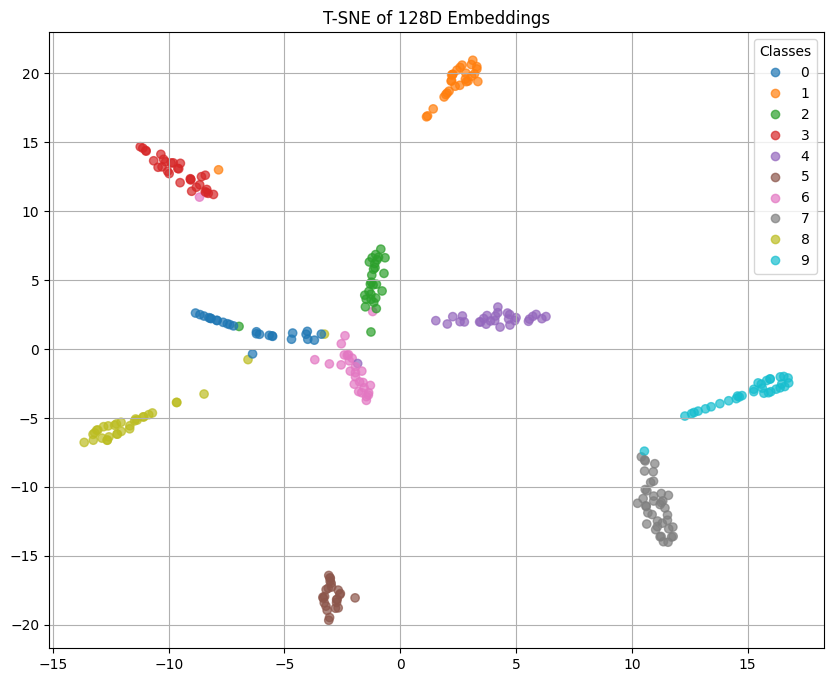

In [37]:
from sklearn.manifold import TSNE
import numpy as np

def extract_embeddings(dataloader, model):
    with torch.no_grad():
        model.eval()
        embeddings = np.zeros((len(dataloader.dataset), 128)) # Changed to 128
        labels = np.zeros(len(dataloader.dataset))
        k = 0
        for images, target in dataloader:
            images = images.cuda()
            embeddings[k:k+len(images)] = model.get_embedding(images).data.cpu().numpy()
            labels[k:k+len(images)] = target.numpy()
            k += len(images)
    return embeddings, labels

# Extract embeddings
train_embeddings, train_labels = extract_embeddings(train_loader, model_128)

# Randomly sample 300 for visualization
idxs = np.random.choice(len(train_embeddings), size=300, replace=False)
sampled_embeddings = train_embeddings[idxs]
sampled_labels = train_labels[idxs]

# Apply T-SNE (reduce 128D to 2D)
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
reduced_embeddings = tsne.fit_transform(sampled_embeddings)

# Plot
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))
scatter = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=sampled_labels, cmap='tab10', alpha=0.7)
plt.legend(*scatter.legend_elements(), title="Classes")
plt.title("T-SNE of 128D Embeddings")
plt.grid(True)
plt.show()

---
The T-SNE plot shows how well the model separates different classes in a 2D space based on the learned embeddings. Each color represents a different class, and we can see that most groups are clearly separated, with only slight overlaps. This indicates that the model has learned useful features. The 2D embedding accuracy is around **81%**, which is good for such a compressed space. However, the full 128-dimensional embeddings achieve a much higher accuracy of **93%**, showing that the original high-dimensional space captures the class differences even better. T-SNE helps us visualize this learning process in a simpler way.


---